## Предсказание уровня удовлетворенности сотрудника и оттока сотрудников

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.

## Цель проекта

1. построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика

2. построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компани
3. дать рекомендации бизнесу

## Описание данных

- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.
- `quit` — увольнение сотрудника из компании

## План исследования
1. [Задача 1](#task1)
    - [Загрузка данных](#load_data1) 
    - [Предобработка данных](#data_prep1)
    - [Исследовательский анализ данных](#data_analyse1)
    - [Подготовка данных](#data_prep_models1)
    - [Обучение модели](#training1)
2. [Задача 2](#task2)
    - [Загрузка данных](#load_data2)
    - [Предобработка данных](#data_prep2)
    - [Исследовательский анализ данных](#data_analyse2)
    - [Добавление нового входного признака](#new_feature)
    - [Подготовка данных](#data_prep_models2)
    - [Обучение модели](#training2)
3. [Вывод](#conc)

## Импорт необходимых библиотек и определение констант

In [7]:
# common
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st

#correlation
import phik
from phik.report import plot_correlation_matrix

# pipeline & preprocessing
# from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    LabelEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler
)

#model selection
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    GridSearchCV
)

from sklearn.feature_selection import (
    SelectKBest,
    f_classif,
    mutual_info_classif,
    f_regression,
    mutual_info_regression
)

#models
from sklearn.linear_model import (
    LinearRegression, 
    LogisticRegression,
    Ridge,
    Lasso
)
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

from catboost import CatBoostRegressor, CatBoostClassifier

#metrics
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    make_scorer
)

from sklearn.impute import SimpleImputer

from imblearn.over_sampling import (
    SMOTE, 
    RandomOverSampler
)
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import shap

In [8]:
RANDOM_STATE = 42

## Задача 1 <a id='task1'>

### Загрузка данных <a id='load_data1'>

In [9]:
train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
X_test = pd.read_csv('/datasets/test_features.csv')
y_test = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

In [10]:
train.head()

id        dept   level workload  employment_years last_year_promo  \
0  155278       sales  junior   medium                 2              no   
1  653870          hr  junior     high                 2              no   
2  184592       sales  junior      low                 1              no   
3  171431  technology  junior      low                 4              no   
4  693419          hr  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  
0                   no                      1   24000                   0.58  
1                   no                      5   38400                   0.76  
2                   no                      2   12000                   0.11  
3                   no                      2   18000                   0.37  
4                   no                      3   22800                   0.20

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [12]:
X_test.head()

id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   
2  467458      sales  middle      low                 5              no   
3  418655      sales  middle      low                 6              no   
4  789145         hr  middle   medium                 5              no   

  last_year_violations  supervisor_evaluation  salary  
0                   no                      5   28800  
1                   no                      4   30000  
2                   no                      4   19200  
3                   no                      4   19200  
4                   no                      5   40800

In [13]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [14]:
X_test.duplicated().sum()

0

In [15]:
y_test.head()

id  job_satisfaction_rate
0  130604                   0.74
1  825977                   0.75
2  418490                   0.60
3  555320                   0.72
4  826430                   0.08

In [16]:
y_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Заметим, что `id` в тестовых данных не совпадают между собой построчно, а это в дальнейшем станет проблемой при обучении модели, поэтому смержим их, а потом снова расделим

In [17]:
X_test = X_test.set_index('id')
y_test = y_test.set_index('id')

X_test = X_test.join(y_test)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 485046 to 771859
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   1998 non-null   object 
 1   level                  1999 non-null   object 
 2   workload               2000 non-null   object 
 3   employment_years       2000 non-null   int64  
 4   last_year_promo        2000 non-null   object 
 5   last_year_violations   2000 non-null   object 
 6   supervisor_evaluation  2000 non-null   int64  
 7   salary                 2000 non-null   int64  
 8   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 220.8+ KB


In [18]:
y_test = X_test['job_satisfaction_rate']
X_test = X_test.drop(columns=['job_satisfaction_rate'])
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 485046 to 771859
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   object
 1   level                  1999 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 205.2+ KB


**Вывод по пункту**:
- видны пропуски в данных, а значит данным нужна предобработка
- типы данных верны
- ошибок в именах столбцов не наблюдается

### Предобработка данных <a id='data_prep1'>

#### Работа с пропусками

Видим маленькое количество пропусков (менее 1% в каждой из выборок), посмотрим на них

In [19]:
train[train['dept'].isna()]

id dept   level workload  employment_years last_year_promo  \
1526  694746  NaN  junior   medium                 5              no   
1630  814624  NaN  junior   medium                 3              no   
1633  475114  NaN  junior     high                 4              no   
2781  497243  NaN  junior   medium                 1              no   
2975  168668  NaN  junior      low                 3              no   
3866  641150  NaN  junior      low                 3              no   

     last_year_violations  supervisor_evaluation  salary  \
1526                   no                      4   21600   
1630                   no                      4   24000   
1633                   no                      4   31200   
2781                   no                      3   26400   
2975                   no                      4   18000   
3866                  yes                      4   12000   

      job_satisfaction_rate  
1526                   0.62  
1630                   0.88  
1633                   0.63  
2781                   0.28  
2975                   0.88  
3866                   0.54

In [20]:
train[train['level'].isna()]

id   dept level workload  employment_years last_year_promo  \
1209  631073  sales   NaN   medium                 1              no   
1469  416327  sales   NaN      low                 1              no   
1745  135043  sales   NaN   medium                 1              no   
2522  998838  sales   NaN   medium                 1              no   

     last_year_violations  supervisor_evaluation  salary  \
1209                   no                      4   27600   
1469                   no                      5   18000   
1745                   no                      3   26400   
2522                   no                      5   27600   

      job_satisfaction_rate  
1209                   0.66  
1469                   0.73  
1745                   0.30  
2522                   0.71

In [21]:
X_test[X_test['dept'].isna()]

dept   level workload  employment_years last_year_promo  \
id                                                               
609865  NaN  junior   medium                 1              no   
832342  NaN  junior   medium                 1              no   

       last_year_violations  supervisor_evaluation  salary  
id                                                          
609865                   no                      1   20400  
832342                   no                      4   28800

In [22]:
X_test[X_test['level'].isna()]

dept level workload  employment_years last_year_promo  \
id                                                               
471990  sales   NaN      low                 1              no   

       last_year_violations  supervisor_evaluation  salary  
id                                                          
471990                   no                      3   12000

На самом деле правильнее всего было бы дропнуть эти наблюдения (из обучающей выборки), потому что их мало, они не представляют собой какую то маленькую группу (например `yes` в бинарных столбцах), обработаем эти наблюдения позже, в пайплайнах

#### Работа с дубликатами

In [23]:
train.duplicated().sum()

0

In [24]:
X_test.reset_index().duplicated().sum() # reset index to check if there any duplicates including id feature

0

In [25]:
def find_implicit_duplicates(df):
    for col in df.select_dtypes(exclude='number').columns:
        print(col)
        print(df.select_dtypes(exclude='number')[col].unique())

In [26]:
find_implicit_duplicates(train)

dept
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level
['junior' 'middle' 'sinior' nan]
workload
['medium' 'high' 'low']
last_year_promo
['no' 'yes']
last_year_violations
['no' 'yes']


In [27]:
find_implicit_duplicates(X_test)

dept
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level
['junior' 'middle' 'sinior' nan]
workload
['medium' 'low' 'high' ' ']
last_year_promo
['no' 'yes']
last_year_violations
['no' 'yes']


Видим `' '` и `nan` зачения в тестовом датасете, которого нет в обчающем. Учтем это при создании пайплайна

Неявных дубликатов не обнаружено

**Вывод по пункту**
- пропуски будут удалены позже
- неявных дубликатов не обнаружено
- работа с именами столбцов и типами данных не требуется
- неизвестные значения в `X_test` обработаем позже

### Исследовательский анализ данных <a id='data_analyse1'>

#### Исследование распределений признаков

In [28]:
def print_hist_box(df, bins=50):
    for col in df.columns:
        print(df[col].describe())
        f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.15, .85)})
    
        sns.boxplot(x=df[col], ax=ax_box)
        ax_box.set_xlabel('')
        ax_box.set_title('Боксплот и распределение признака ' + col)
        plt.ylabel('Количество элементов признака ' + col)
        plt.xlabel('Значения элементов признака ' + col)
        sns.histplot(x=df[col], bins=bins, kde=True, ax=ax_hist)
    
        ax_box.set(yticks=[])
        sns.despine(ax=ax_hist)
        sns.despine(ax=ax_box, left=True)
        plt.show()

In [29]:
def fmt(x): #func to determine labels on pie plot
    return '{:.1f}%\n{:.2f}'.format(x, total * x / 100)

In [30]:
def print_pie_bar(df):
    for col in df.columns:
        print(df[col].describe())
        ax = sns.countplot(x=df[col], order=df[col].value_counts().index)
        for rect in ax.patches:
            ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 0.75,rect.get_height(), horizontalalignment='center', fontsize=11)
        plt.ylabel('Количество')
        plt.xlabel('Значение')
        plt.title('Столбчатая диаграмма признака ' + col)
        ax.tick_params(axis='x', labelrotation=90)
        plt.show()
        global total
        total = df[col].count()
        df[col].value_counts().plot(kind='pie', autopct=fmt)
        plt.title('Круговая диаграмма признака ' + col)
        plt.ylabel('')
        plt.show()

count    4000.000000
mean        3.718500
std         2.542513
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


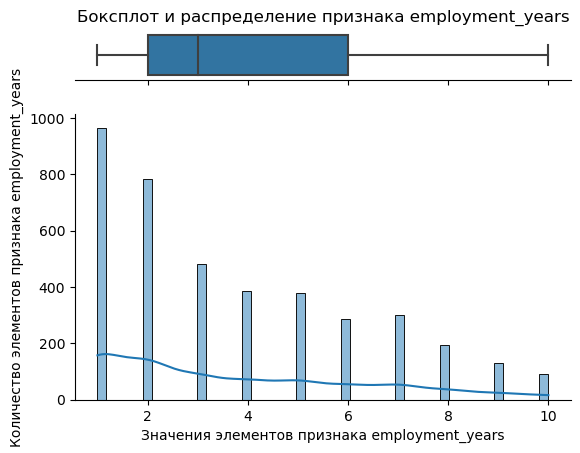

count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64


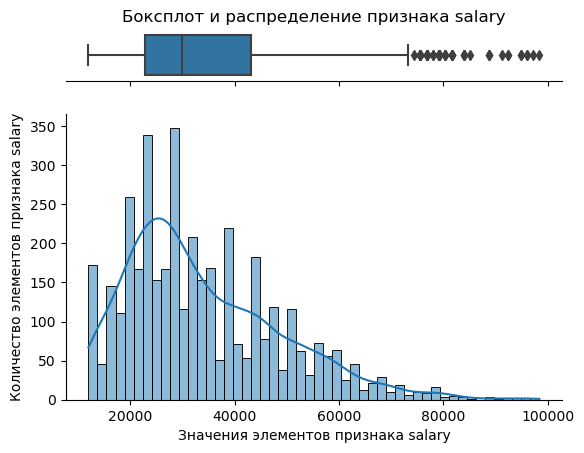

count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64


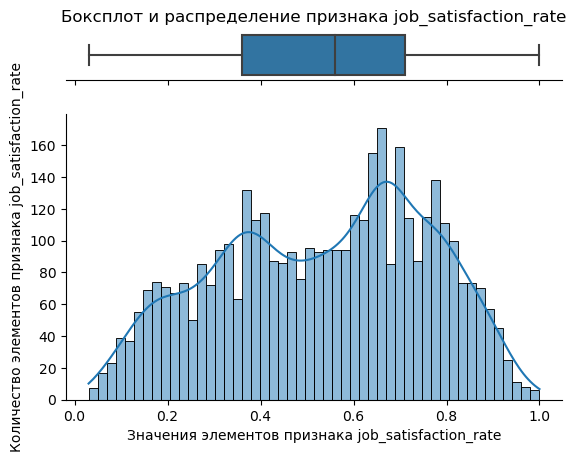

In [31]:
print_hist_box(train.select_dtypes(include='number').drop(columns=['id', 'supervisor_evaluation'])) # supervisor_evaluation is categorial

Для количественных признаков видим:
- Признак `employment_years` - стаж работы в компании - имеет ненормальное распределение, выбросов нет
- Признак `salary` - ЗП - имеет ненормальное распределение, выбросы видны на боксплоте, посмотрим на них:

In [32]:
train[train['salary'] > 80000]['employment_years'].mean()

6.576923076923077

В целом все нормально, заработная плата может достигать 100 000 рублей, и у таких сотрудников стаж работы в этой компании около 6,5 лет. Выбросы аномалиями не являюься. оставляем 

И наконец `job_satisfaction_rate` - таргет имеет распределение, близкое кнормальному, но при этом видим 2 пика. Выбросов нет

count      3994
unique        5
top       sales
freq       1512
Name: dept, dtype: object


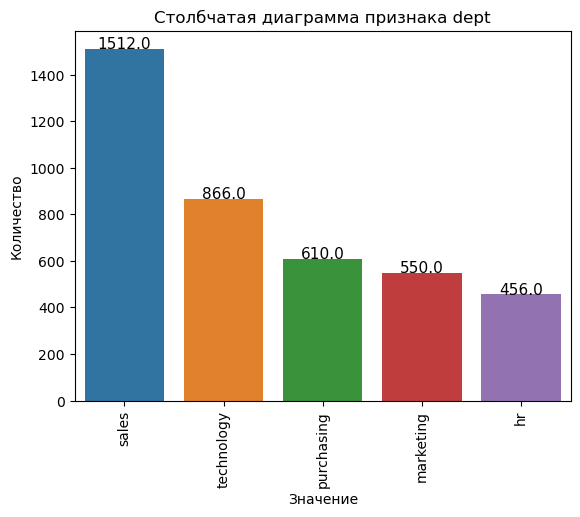

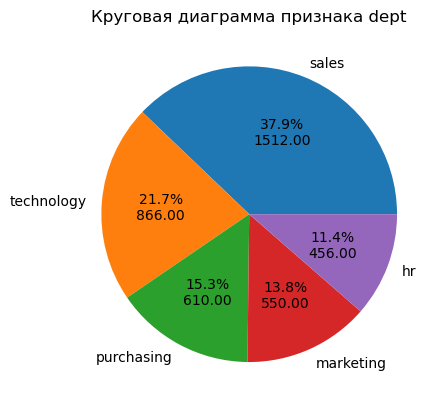

count       3996
unique         3
top       junior
freq        1894
Name: level, dtype: object


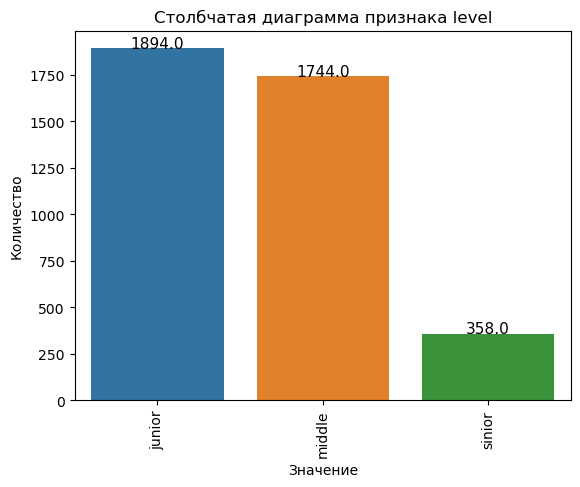

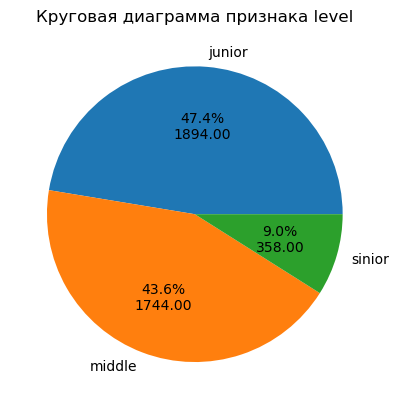

count       4000
unique         3
top       medium
freq        2066
Name: workload, dtype: object


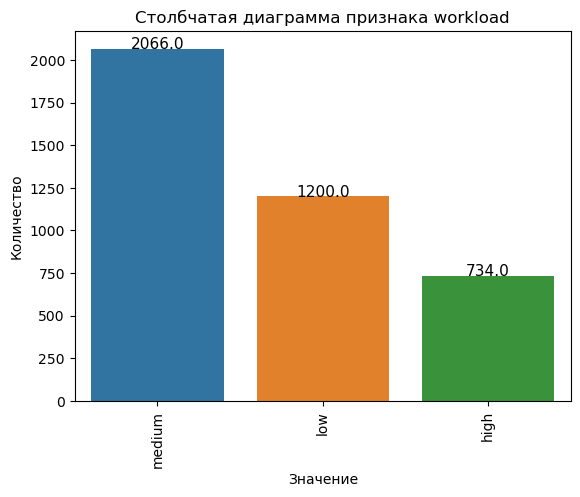

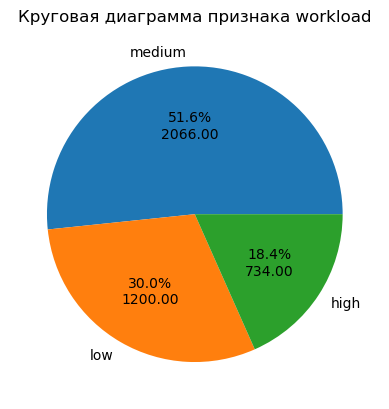

count     4000
unique       2
top         no
freq      3880
Name: last_year_promo, dtype: object


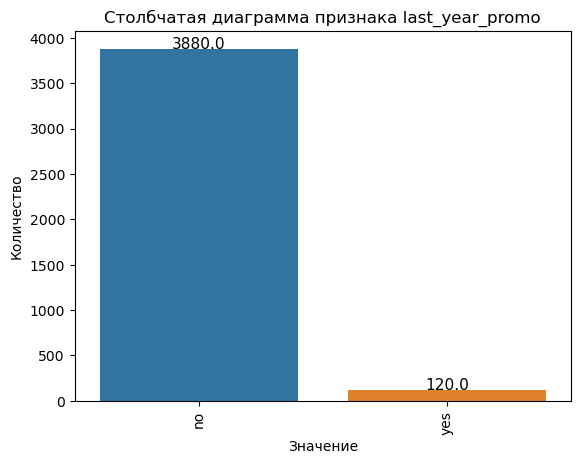

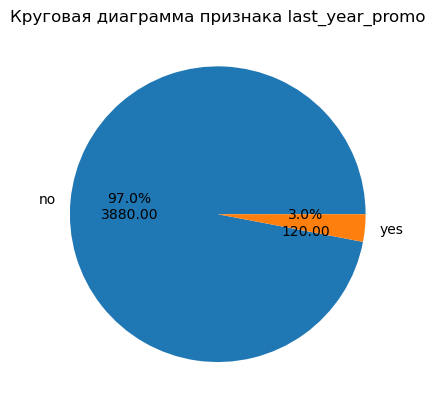

count     4000
unique       2
top         no
freq      3441
Name: last_year_violations, dtype: object


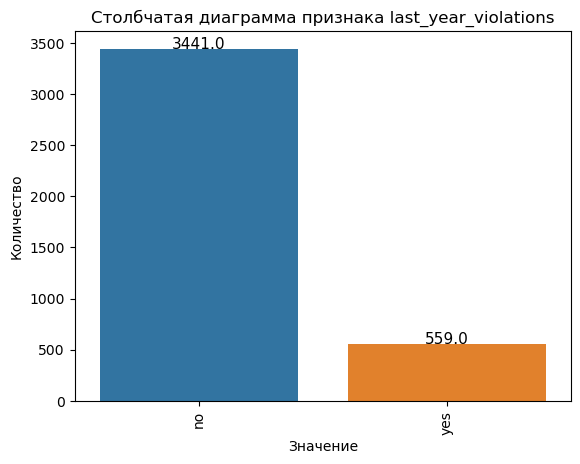

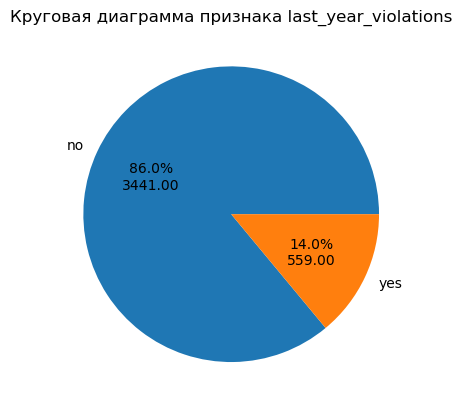

count    4000.000000
mean        3.476500
std         1.008812
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


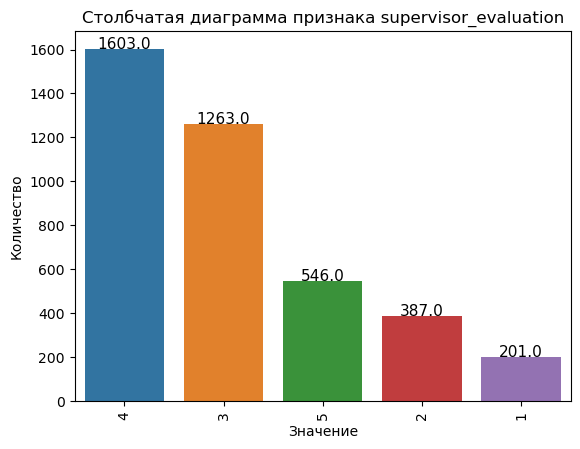

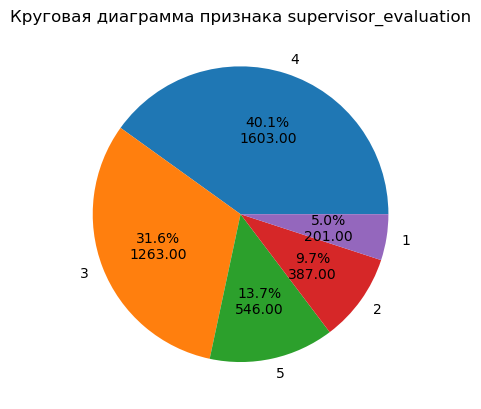

In [33]:
print_pie_bar(pd.concat([train.select_dtypes(exclude='number'), train['supervisor_evaluation']], axis = 1))

У категориальных признаков можем видеть интересную картину: 
- признак `dept` - отдел - имеет +- равное распределение сотрудников по отделам, только отдел продаж имеет большой перевес по сотрудникам
- признак `level` - должность - сеньеров меньше всех, джунов и мидлов +- поровну, все нормально
- признак `workload` - загруженность - тоже без сюрпризов
- признаки
  1. `last_year_promo` - было ли повышение в прошлом году
  2. `last_year_violations` - нарушал ли сотрудник трудовой договор <br>
  крайне несбалнсированы, что в целом более чем логично и соответствует действительности, но что делать с этими столбцами посмотрим позже
- признак `supervisor_evaluation` - оценка работы сотрудника - также соответсвует действительности и неожиданностей нет

#### Корреляционный анализ

Text(0.5, 1.0, 'корреляция $\\phi_K$')

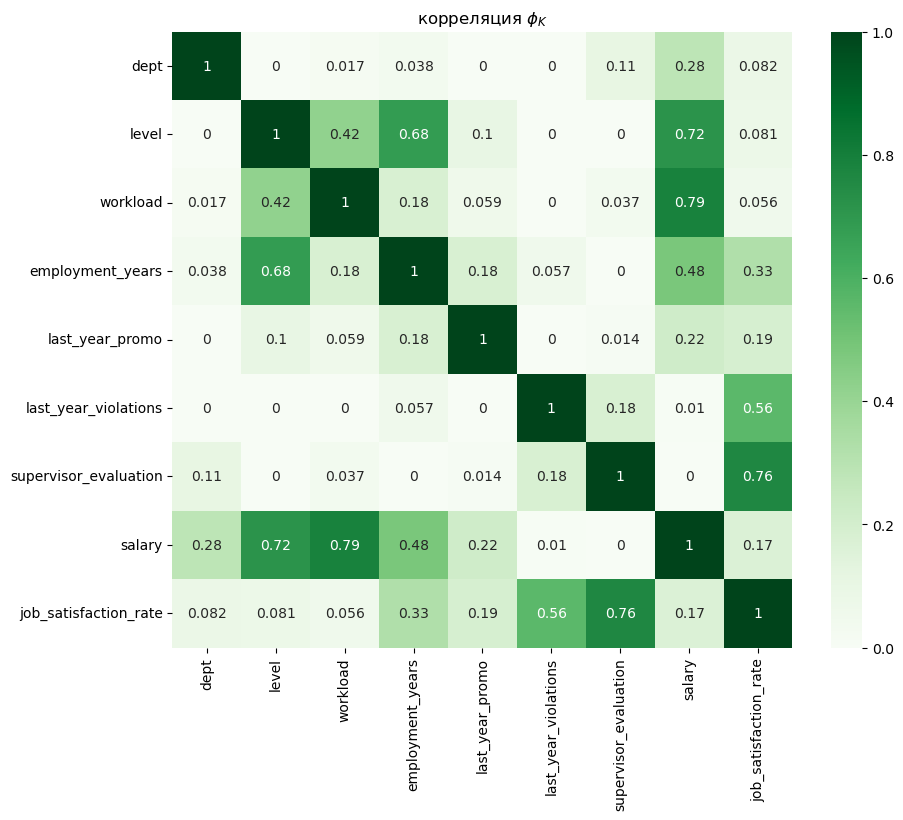

In [34]:
interval_columns = ['employment_years', 'job_satisfaction_rate', 'salary']

plt.figure(figsize=(10, 8))
sns.heatmap(train.drop(columns=['id']).phik_matrix(interval_cols=interval_columns), annot=True, cmap='Greens')
plt.title(r'корреляция $\phi_K$')

По матрице корреляций видим интресную картину:
- сильнее всего на удовдетворенность влияет оценка начальника, что логично отчасти (никому не нравится, когда начальник тобой недоволен)
- зарплата слабо коррелирует с с удовлетворенностью и уровнем должности, но хорошо коррелирует с загруженностью (не является мультиколлинеарностью)
- также сильную связь с таргетом имеет признак нарешения трудового договора.

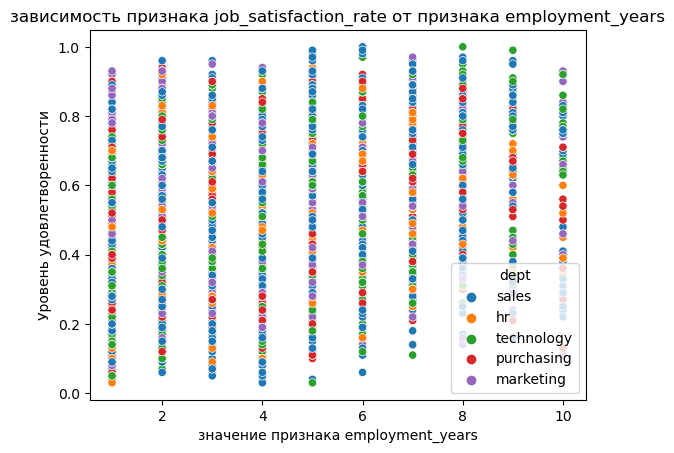

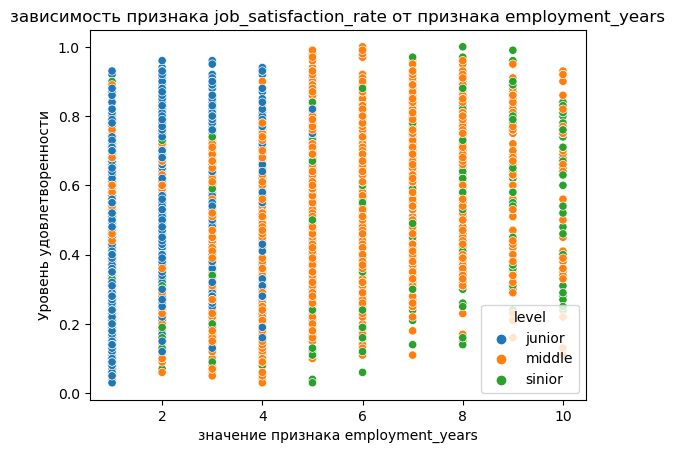

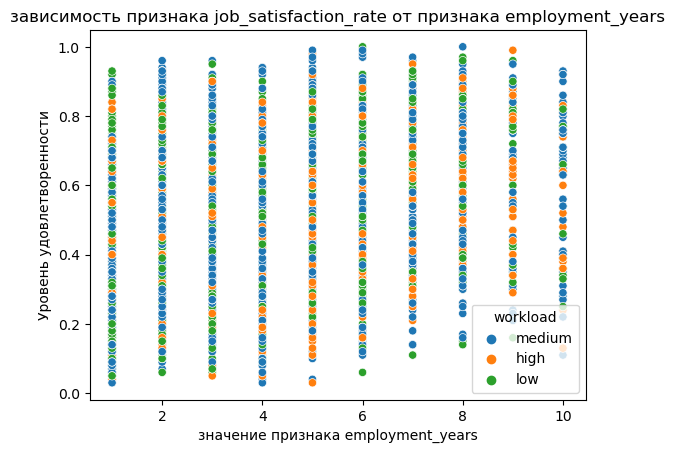

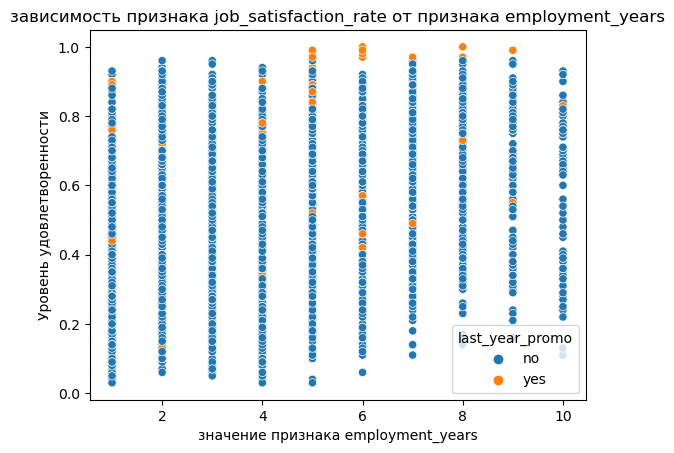

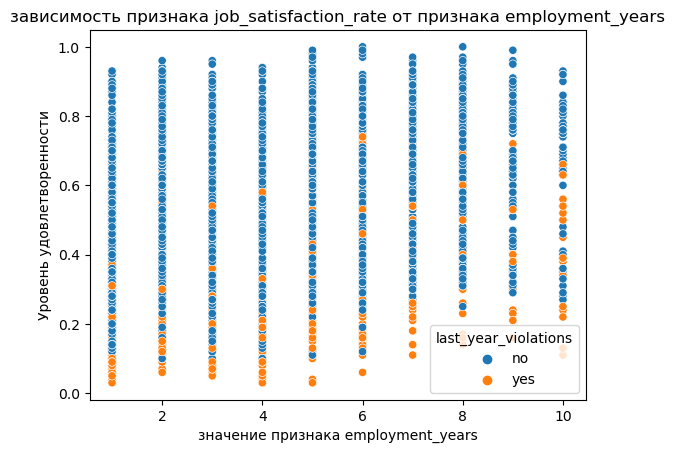

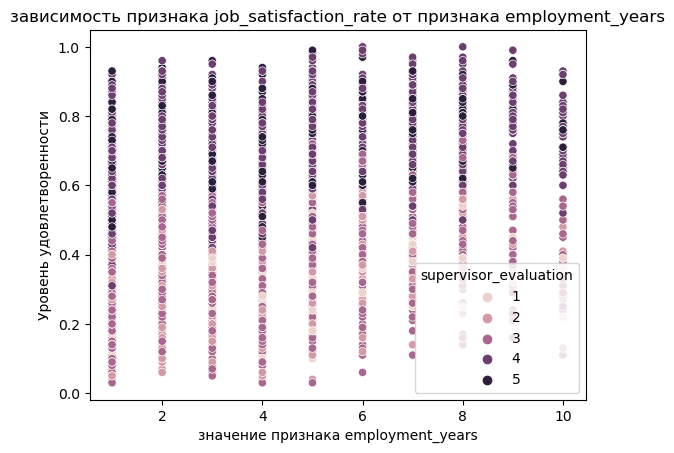

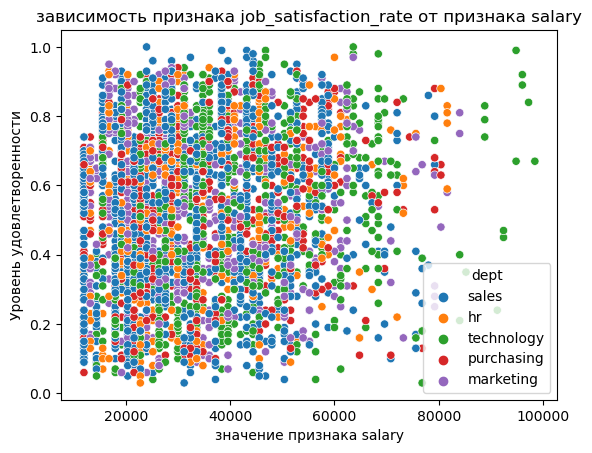

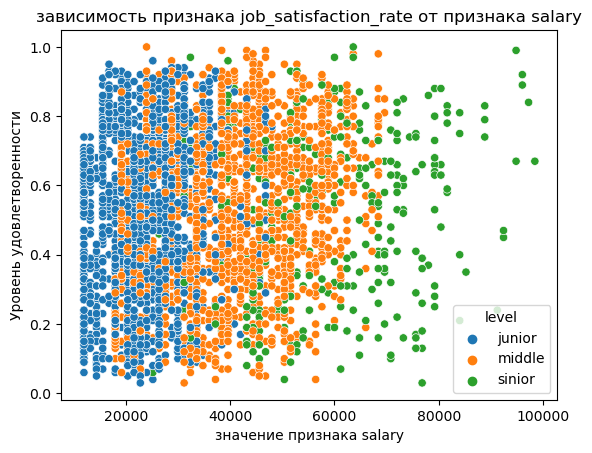

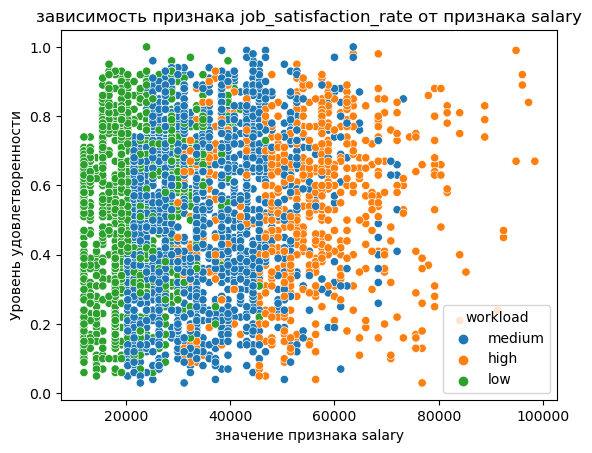

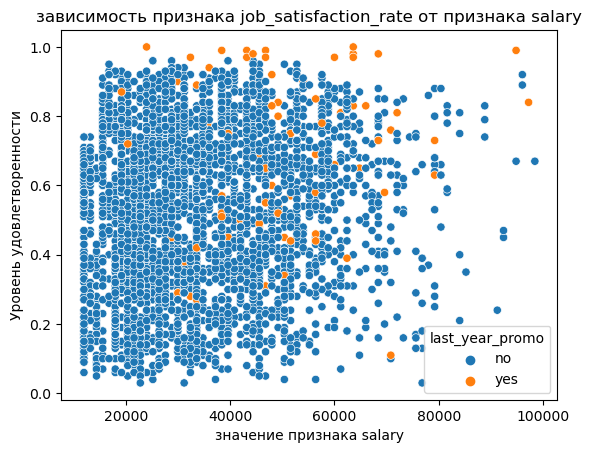

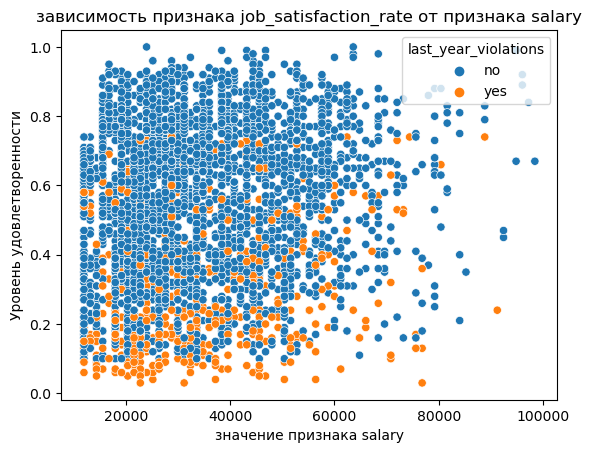

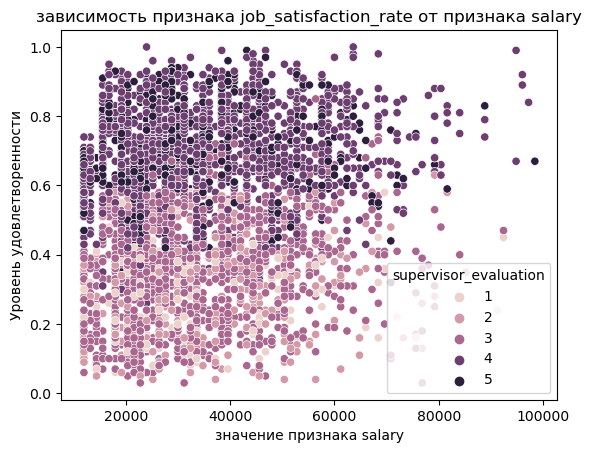

In [35]:
for i, col_num in enumerate(train.drop(columns=['id', 'job_satisfaction_rate', 'supervisor_evaluation']).select_dtypes(include='number').columns):
    for j, col_cat in enumerate(pd.concat([train.drop(columns=['id']).select_dtypes(exclude='number'), train['supervisor_evaluation']], axis=1).columns):
        ax = sns.scatterplot(data=train, x=col_num, y='job_satisfaction_rate', hue=col_cat)
        plt.title('зависимость признака job_satisfaction_rate от признака ' + col_num)
        plt.ylabel('Уровень удовлетворенности')
        plt.xlabel('значение признака ' + col_num)
        plt.show()

Итак, выводы сделанные по матрице корреляции подтвердились:
- сильнее всего на удовдетворенность влияет оценка начальника, наличие нарушений договора, стаж работы, повышение за последний год)

**Вывод по пунтку**: Был проведен исследовательский и корреляционный анализ данных
- были выявлены зависимости с таргетом
- изучено распределение каждого признака
- стоит закодировать порядковые признаки (отбор признаков сделаем в следующем пункте) с помощью `OrdinalEncoder`
- стоит закодировать номинальные и бинарные признаки с помощью `OneHotEncoder`
- масштабирование попробуем разными способами
- причем все выявленные сильные зависимости - линейные

### Подготовка данных <a id='data_prep_models1'>

Далее выделим таргет и признаковое пространство

In [36]:
X_train = train.drop(columns=['id', 'job_satisfaction_rate'])
y_train = train['job_satisfaction_rate']

In [37]:
X_train.head()

dept   level workload  employment_years last_year_promo  \
0       sales  junior   medium                 2              no   
1          hr  junior     high                 2              no   
2       sales  junior      low                 1              no   
3  technology  junior      low                 4              no   
4          hr  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary  
0                   no                      1   24000  
1                   no                      5   38400  
2                   no                      2   12000  
3                   no                      2   18000  
4                   no                      3   22800

In [38]:
y_train.head()

0    0.58
1    0.76
2    0.11
3    0.37
4    0.20
Name: job_satisfaction_rate, dtype: float64

Отберем признаки: уровень должности и занятость закочируем с помощью `OrdinalEncoder`, потому что мы можем сказать, что одно значение больше другого, остальные категориальные закодируем с помощью `OneHotEncoder`

In [39]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = train.drop(columns=['id', 'supervisor_evaluation', 'job_satisfaction_rate']).select_dtypes(include='number').columns

In [40]:
ohe_pipe = Pipeline(
    [
        ('ohe_imp', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
)

In [41]:
ord_pipe = Pipeline(
    [
        ('ord_imp', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(categories=
                              [
                                  ['junior', 'middle', 'sinior'],
                                  ['low', 'medium', 'high']
                              ], handle_unknown='use_encoded_value', unknown_value=np.nan)),
        ('imp_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [42]:
col_transformer = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

**Вывод по пункту**: был собран пайплайн для подготовки признаков, так же было учтено, что надо заполнить пропуски, которые не были заполнены при предобработке, а также то, что в тестовой выборке есть неизвестные данные. 

### Обучение моделей <a id='training1'>

Начнем с того, что нужно создать собственную метрику SMAPE.

In [43]:
def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)) * 2)

In [44]:
smape_score = make_scorer(smape, greater_is_better=False)

Теперь объявим финальный пайплайн и будем подбирать гиперпараметры

In [45]:
final_pipe = Pipeline(
    [
        ('prep', col_transformer),
        ('feature_selection', SelectKBest(score_func=f_regression, k=11)),
        ('models', LinearRegression())
    ]
)

In [46]:
params = [
    {
        'models': [Ridge(random_state=RANDOM_STATE), Lasso(random_state=RANDOM_STATE)],
        'models__alpha': [0.1, 0.5, 1, 5, 10],
        'prep__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
        # 'feature_selection__k': range(9, 11)
    },
    {
        'models': [SVR()],
        'models__C': [100, 150, 200],
        'prep__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
        # 'feature_selection__k' : range(9, 11) # found optimal
    },
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(65, 70),
        'models__min_samples_split': range(14, 17),
        'models__min_samples_leaf': range(3, 5),
        # 'feature_selection__k' : range(9, 11),
        # 'feature_selection__score_func': [f_regression, mutual_info_regression],
        'prep__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
        
    }
    
]

In [47]:
grid_search = GridSearchCV(
    final_pipe,
    param_grid=params,
    n_jobs=-1,
    scoring=smape_score,
)

In [48]:
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('ohe_imp',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['dept',
                                                                          'last_year_promo',
                                                                          'last_year_violations']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('ord_imp',
                                                                                          SimpleImputer(strategy='m...
                                        RobustScaler(), 'passthrough']},
                         {'models': [DecisionTreeRegressor(max_depth=65,
                                                           min_samples_leaf=3,
                                                           min_samples_split=14,
                                                           random_state=42)],
                          'models__max_depth': range(65, 70),
                          'models__min_samples_leaf': range(3, 5),
                          'models__min_samples_split': range(14, 17),
                          'prep__num': [StandardScaler(), MinMaxScaler(),
                                        RobustScaler(), 'passthrough']}],
             scoring=make_scorer(smape, greater_is_better=False))

In [49]:
grid_search.best_estimator_

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe_imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord_imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',...
                                                                  ('imp_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload']),
                                                 ('num', RobustScaler(),
                                                  Index(['employment_years', 'salary'], dtype='object'))])),
                ('feature_selection',
                 SelectKBest(k=11,
                             score_func=<function f_regression at 0x00000259AD6268E0>)),
                ('models',
                 DecisionTreeRegressor(max_depth=65, min_samples_leaf=3,
                                       min_samples_split=14,
                                       random_state=42))])

In [50]:
grid_search.best_params_

{'models': DecisionTreeRegressor(max_depth=65, min_samples_leaf=3, min_samples_split=14,
                       random_state=42),
 'models__max_depth': 65,
 'models__min_samples_leaf': 3,
 'models__min_samples_split': 14,
 'prep__num': RobustScaler()}

In [51]:
np.abs(grid_search.best_score_)

14.574840280189576

In [52]:
smape(y_test, grid_search.predict(X_test))

C:\Users\Maxim\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


13.643294143435302

#### Анализ работы всех моделей

Посмотрим на результаты всех моделей

In [53]:
res = pd.DataFrame(grid_search.cv_results_)
res

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.051677      0.000399         0.013769        0.001823   
1         0.052674      0.001163         0.013769        0.001463   
2         0.051693      0.000983         0.010822        0.003104   
3         0.023760      0.011726         0.006868        0.001116   
4         0.018452      0.003885         0.008577        0.001739   
..             ...           ...              ...             ...   
167       0.040292      0.002646         0.012567        0.001017   
168       0.046277      0.007507         0.013564        0.000489   
169       0.040292      0.000798         0.013164        0.000746   
170       0.042087      0.001163         0.013763        0.001163   
171       0.034707      0.002130         0.009375        0.001850   

                                          param_models param_models__alpha  \
0                               Ridge(random_state=42)                 0.1   
1                               Ridge(random_state=42)                 0.1   
2                               Ridge(random_state=42)                 0.1   
3                               Ridge(random_state=42)                 0.1   
4                               Ridge(random_state=42)                 0.5   
..                                                 ...                 ...   
167  DecisionTreeRegressor(max_depth=65, min_sample...                 NaN   
168  DecisionTreeRegressor(max_depth=65, min_sample...                 NaN   
169  DecisionTreeRegressor(max_depth=65, min_sample...                 NaN   
170  DecisionTreeRegressor(max_depth=65, min_sample...                 NaN   
171  DecisionTreeRegressor(max_depth=65, min_sample...                 NaN   

      param_prep__num param_models__C param_models__max_depth  \
0    StandardScaler()             NaN                     NaN   
1      MinMaxScaler()             NaN                     NaN   
2      RobustScaler()             NaN                     NaN   
3         passthrough             NaN                     NaN   
4    StandardScaler()             NaN                     NaN   
..                ...             ...                     ...   
167       passthrough             NaN                      69   
168  StandardScaler()             NaN                      69   
169    MinMaxScaler()             NaN                      69   
170    RobustScaler()             NaN                      69   
171       passthrough             NaN                      69   

    param_models__min_samples_leaf param_models__min_samples_split  \
0                              NaN                             NaN   
1                              NaN                             NaN   
2                              NaN                             NaN   
3                              NaN                             NaN   
4                              NaN                             NaN   
..                             ...                             ...   
167                              4                              15   
168                              4                              16   
169                              4                              16   
170                              4                              16   
171                              4                              16   

                                                params  split0_test_score  \
0    {'models': Ridge(random_state=42), 'models__al...         -25.193761   
1    {'models': Ridge(random_state=42), 'models__al...         -25.184509   
2    {'models': Ridge(random_state=42), 'models__al...         -25.193493   
3    {'models': Ridge(random_state=42), 'models__al...         -25.194123   
4    {'models': Ridge(random_state=42), 'models__al...         -25.181761   
..                                                 ...                ...   
167  {'models': DecisionTreeRegressor(max_depth=65,...         -15.056234   
1

Визуализируем:

Text(0, 0.5, 'количество моделей с таким качеством')

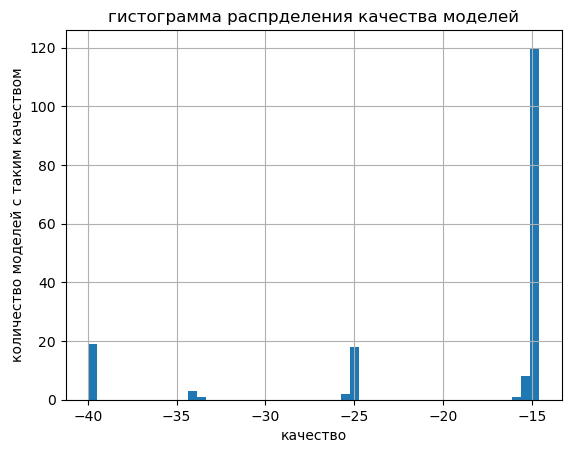

In [54]:
res['mean_test_score'].hist(bins=50)
plt.title('гистограмма распрделения качества моделей')
plt.xlabel('качество')
plt.ylabel('количество моделей с таким качеством')

Большинство моделей дают оценку ниже или около 15, но есть и те, какие-то дают 40...

**Вывод по пункту**: Были опробованы слудующие модели и пдобраны к ним гиперпараментры:
- Ridge
- Lasso
- LinearRegression
- SVR
- DecisionTreeRegressor
- Лушчей стала модель `DecisionTreeRegressor` со следующими гиперпараметрами:
    1. 'prep__num': `StandardScaler()`,
    2. 'models__min_samples_split': 4,
    3. 'models__min_samples_leaf': 3,
    4. 'models__max_depth': 45,
    5. 'models': `DecisionTreeRegressor(random_state=RANDOM_STATE)`,
    6. 'feature_selection__score_func': `f_regression`,
    7. 'feature_selection__k': 10
- качество модели по метрике `smape` на обучающей выборке составило 14.57
- качество модели по метрике `smape` на тествовой выборке составило 13.64

#### Анализ важности признаков

Проведем его для того, чтобы в дальнейшем дать рекомендации бизнесу

Но для начала нужно отобраться все фичи, которые были использованы при обучении 

In [55]:
X_train_p = pd.DataFrame(col_transformer.fit_transform(X_train), 
                         columns=list(col_transformer.transformers_[0][1]['ohe'].get_feature_names_out()) + 
                         ord_columns + 
                         list(num_columns) +
                         ['supervisor_evaluation']
                        ) # encode & scale
X_train_p = X_train_p.iloc[:, grid_search.best_estimator_.named_steps['feature_selection'].get_support(indices=True)] # taking best features
X_train_p.head(10)

x0_marketing  x0_purchasing  x0_sales  x0_technology  x1_yes  x2_yes  \
0           0.0            0.0       1.0            0.0     0.0     0.0   
1           0.0            0.0       0.0            0.0     0.0     0.0   
2           0.0            0.0       1.0            0.0     0.0     0.0   
3           0.0            0.0       0.0            1.0     0.0     0.0   
4           0.0            0.0       0.0            0.0     0.0     0.0   
5           0.0            0.0       0.0            0.0     0.0     0.0   
6           0.0            0.0       1.0            0.0     0.0     0.0   
7           0.0            1.0       0.0            0.0     0.0     0.0   
8           0.0            0.0       0.0            0.0     0.0     0.0   
9           0.0            0.0       0.0            1.0     0.0     0.0   

   level  workload  employment_years    salary  supervisor_evaluation  
0    0.0       1.0         -0.675991 -0.666273                    1.0  
1    0.0       2.0         -0.675991  0.300245                    5.0  
2    0.0       0.0         -1.069351 -1.471705                    2.0  
3    0.0       0.0          0.110731 -1.068989                    2.0  
4    0.0       1.0         -1.069351 -0.746816                    3.0  
5    1.0       0.0          1.290813 -0.263557                    4.0  
6    2.0       1.0          2.077535  1.508392                    3.0  
7    1.0       2.0          2.077535  1.266763                    3.0  
8    0.0       0.0         -1.069351 -1.391162                    2.0  
9    1.0       2.0          0.897453  1.347306                    3.0

In [56]:
importance = pd.DataFrame({'feature': X_train_p.columns, 'importance': np.abs(grid_search.best_estimator_.named_steps['models'].feature_importances_)}).sort_values(by='importance', ascending=False)
importance

feature  importance
10  supervisor_evaluation    0.682200
9                  salary    0.077017
8        employment_years    0.074429
5                  x2_yes    0.051516
6                   level    0.049167
7                workload    0.020227
2                x0_sales    0.012105
4                  x1_yes    0.011278
3           x0_technology    0.010190
0            x0_marketing    0.009093
1           x0_purchasing    0.002777

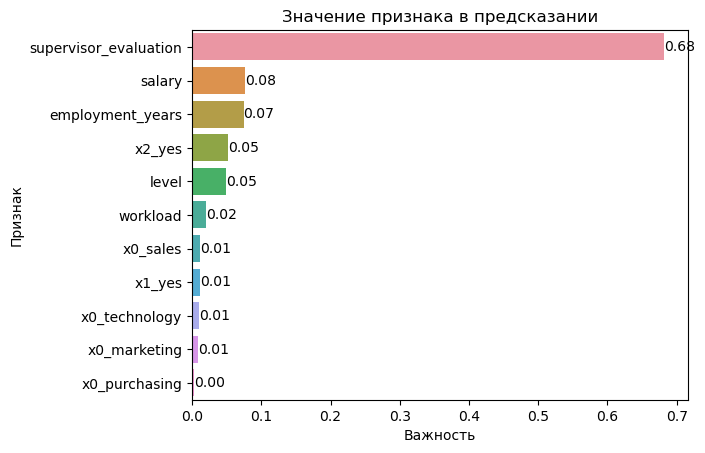

In [57]:
ax = sns.barplot(data=importance, x='importance', y='feature')
plt.title('Значение признака в предсказании')
plt.xlabel('Важность')
plt.ylabel('Признак')
for rect in ax.patches:
        width = rect.get_width()    # get bar length
        ax.text(width,
            rect.get_y() + rect.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.2f}'.format(width),
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment

### Выводы по задаче

In [58]:
train.head()

id        dept   level workload  employment_years last_year_promo  \
0  155278       sales  junior   medium                 2              no   
1  653870          hr  junior     high                 2              no   
2  184592       sales  junior      low                 1              no   
3  171431  technology  junior      low                 4              no   
4  693419          hr  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  
0                   no                      1   24000                   0.58  
1                   no                      5   38400                   0.76  
2                   no                      2   12000                   0.11  
3                   no                      2   18000                   0.37  
4                   no                      3   22800                   0.20

Повторим часть вывода из предыдущего пункта: <br>
- Лушчей стала модель `DecisionTreeRegressor` со следующими гиперпараметрами:
    1. 'prep__num': `StandardScaler()`,
    2. 'models__min_samples_split': 4,
    3. 'models__min_samples_leaf': 3,
    4. 'models__max_depth': 45,
    5. 'models': `DecisionTreeRegressor(random_state=RANDOM_STATE)`,
    6. 'feature_selection__score_func': `f_regression`,
    7. 'feature_selection__k': 10
- Лучше всех справилась модель дерева решений, вероятно потому, что из 8 признаков обучающей выборки 6 являются категориальными, а древесные модели хорошо работают с категориальными переменными

## Задача 2 <a id='task2'>

### Загрузка данных <a id='load_data2'>

In [59]:
train_clf = pd.read_csv('/datasets/train_quit.csv')
X_test_clf = pd.read_csv('/datasets/test_features.csv')
y_test_clf = pd.read_csv('/datasets/test_target_quit.csv')

In [60]:
train_clf.head()

id        dept   level workload  employment_years last_year_promo  \
0  723290       sales  middle     high                 2              no   
1  814010       sales  junior   medium                 2              no   
2  155091  purchasing  middle   medium                 5              no   
3  257132       sales  junior   medium                 2              no   
4  910140   marketing  junior   medium                 2              no   

  last_year_violations  supervisor_evaluation  salary quit  
0                   no                      4   54000   no  
1                   no                      4   27600   no  
2                   no                      1   37200   no  
3                  yes                      3   24000  yes  
4                   no                      5   25200   no

In [61]:
train_clf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [62]:
X_test_clf.head()

id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   
2  467458      sales  middle      low                 5              no   
3  418655      sales  middle      low                 6              no   
4  789145         hr  middle   medium                 5              no   

  last_year_violations  supervisor_evaluation  salary  
0                   no                      5   28800  
1                   no                      4   30000  
2                   no                      4   19200  
3                   no                      4   19200  
4                   no                      5   40800

In [63]:
X_test_clf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


X_test_clf точно такой же, как и X_test

In [64]:
y_test_clf.head()

id quit
0  999029  yes
1  372846   no
2  726767   no
3  490105   no
4  416898  yes

In [65]:
y_test_clf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Также смержим и расделим `X_test` и `y_test`, потому что id не совпадют

In [66]:
X_test_clf = X_test_clf.set_index('id')
y_test_clf = y_test_clf.set_index('id')

X_test_clf = X_test_clf.join(y_test_clf)
X_test_clf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 485046 to 771859
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   object
 1   level                  1999 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
 8   quit                   2000 non-null   object
dtypes: int64(3), object(6)
memory usage: 220.8+ KB


In [67]:
y_test_clf = X_test_clf['quit']
X_test_clf = X_test_clf.drop(columns=['quit'])
X_test_clf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 485046 to 771859
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   object
 1   level                  1999 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 205.2+ KB


**Вывод по пункту**: как и для прошлой задачи видим, что есть те же пропуски, потому что они в том же датасете, типы данных соответсвуют. В следующем пункте проведем работу с дубликатми

### Предобработка данных <a id='data_prep2'>

In [68]:
train_clf.duplicated().sum()

0

In [69]:
X_test_clf.reset_index().duplicated().sum()

0

In [70]:
find_implicit_duplicates(train_clf)

dept
['sales' 'purchasing' 'marketing' 'technology' 'hr']
level
['middle' 'junior' 'sinior']
workload
['high' 'medium' 'low']
last_year_promo
['no' 'yes']
last_year_violations
['no' 'yes']
quit
['no' 'yes']


In [71]:
find_implicit_duplicates(X_test_clf)

dept
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level
['junior' 'middle' 'sinior' nan]
workload
['medium' 'low' 'high' ' ']
last_year_promo
['no' 'yes']
last_year_violations
['no' 'yes']


Такая же ситуация, как и на прошлой задаче, все неизвестные значения обработаем в пайплайнах позже

### Исследовательский анализ данных <a id='data_analyse2'>

Для начала проведем тот же исследовательский анализ данных как и для первой задачи

#### Исследование распределений

count    4000.000000
mean        3.701500
std         2.541852
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


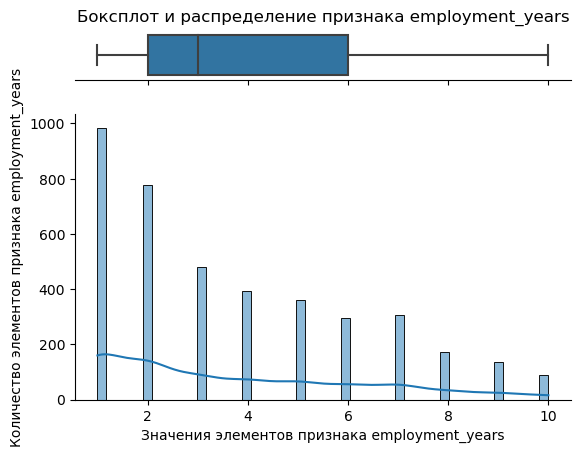

count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64


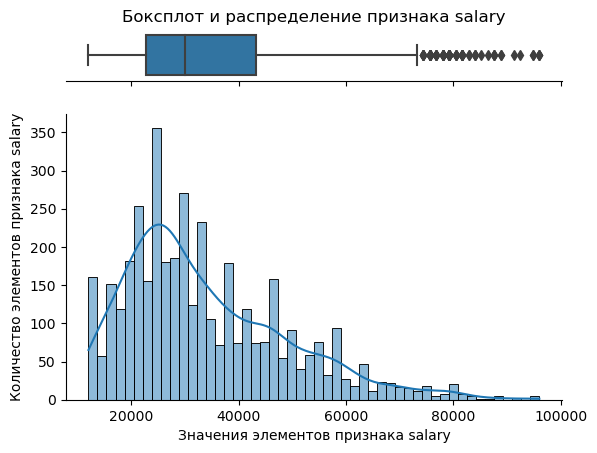

In [72]:
print_hist_box(train_clf.select_dtypes(include='number').drop(columns=['id', 'supervisor_evaluation'])) # supervisor_evaluation is categorial

Та же картина, что и для первой задачи - ненормальное распределение для всех признаков, выбросов не являются аномалиями.

count      4000
unique        5
top       sales
freq       1438
Name: dept, dtype: object


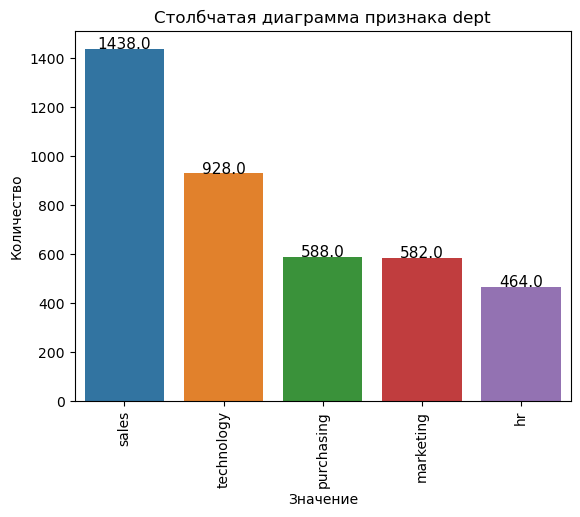

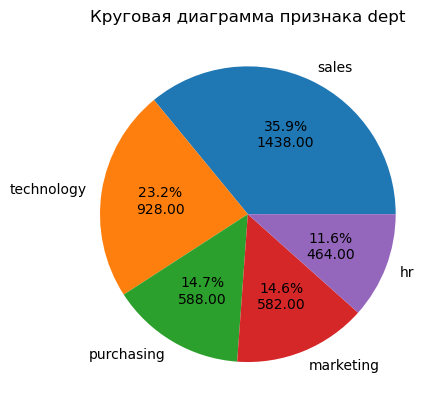

count       4000
unique         3
top       junior
freq        1949
Name: level, dtype: object


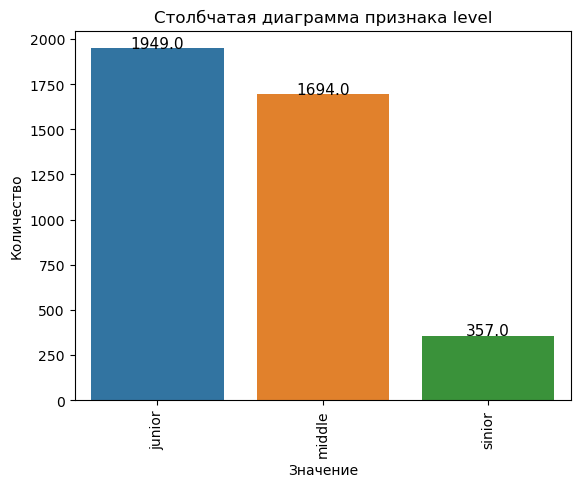

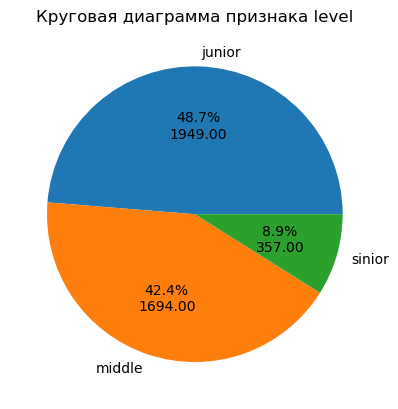

count       4000
unique         3
top       medium
freq        2118
Name: workload, dtype: object


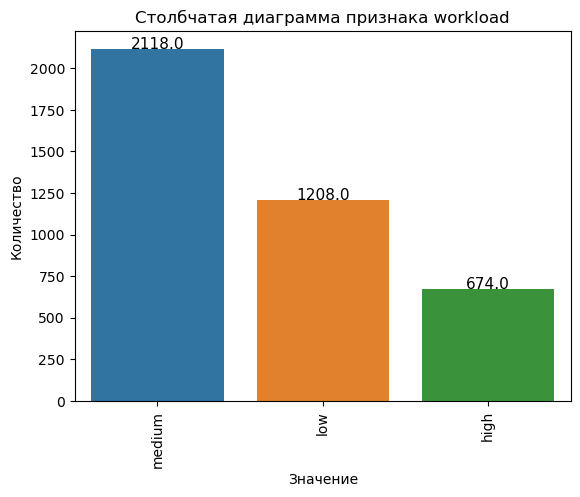

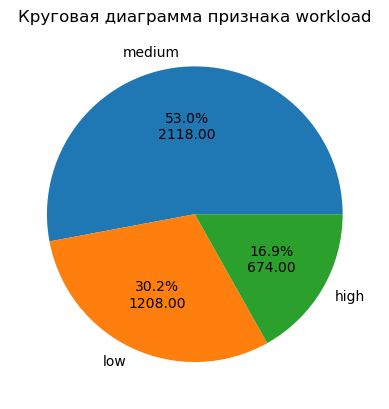

count     4000
unique       2
top         no
freq      3887
Name: last_year_promo, dtype: object


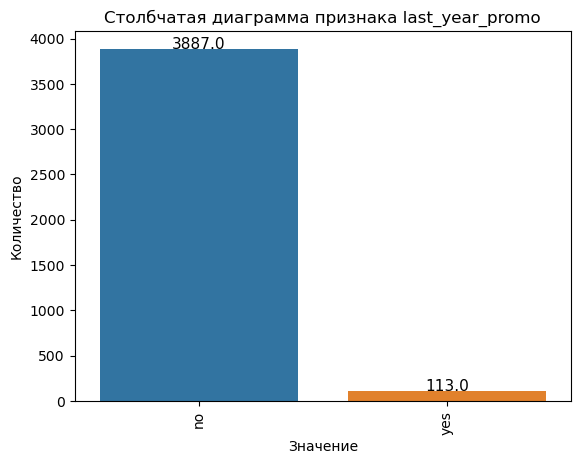

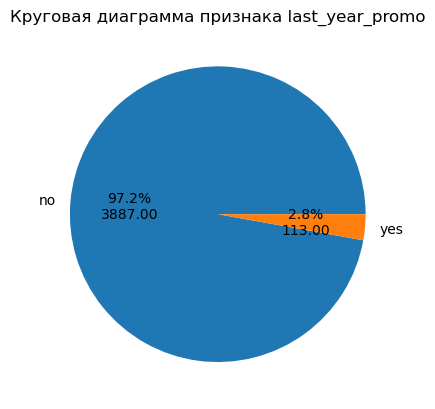

count     4000
unique       2
top         no
freq      3455
Name: last_year_violations, dtype: object


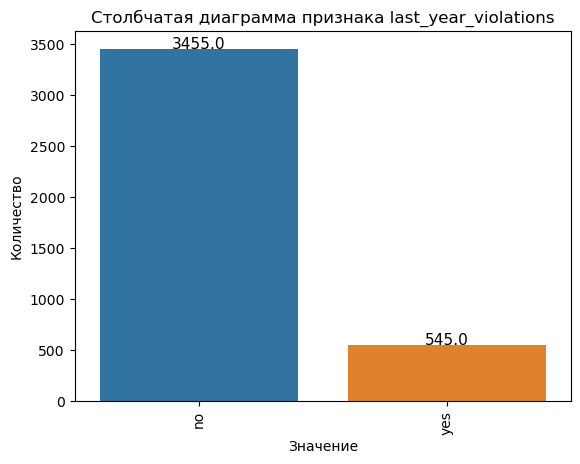

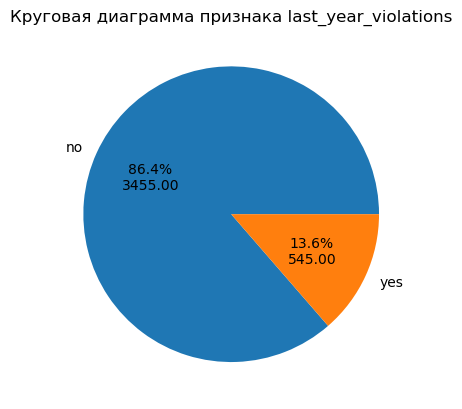

count     4000
unique       2
top         no
freq      2872
Name: quit, dtype: object


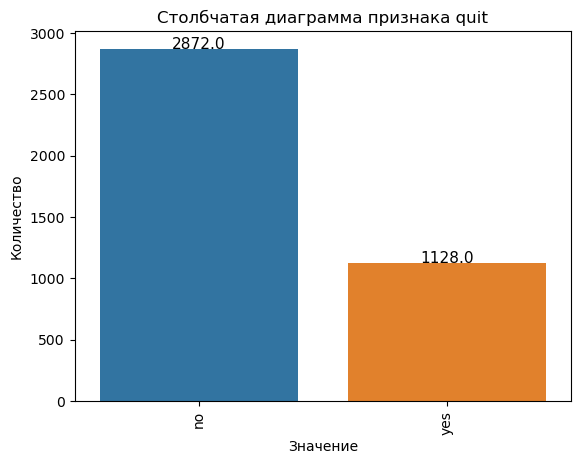

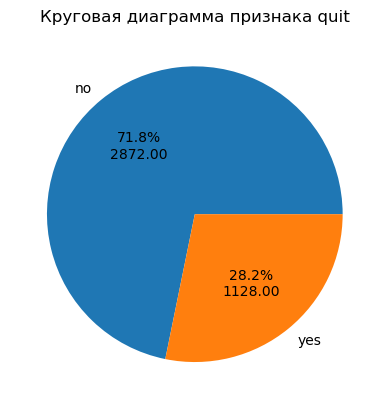

count    4000.000000
mean        3.474750
std         1.004049
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


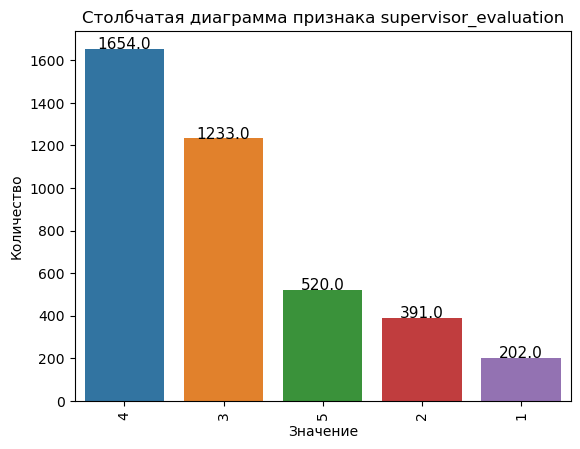

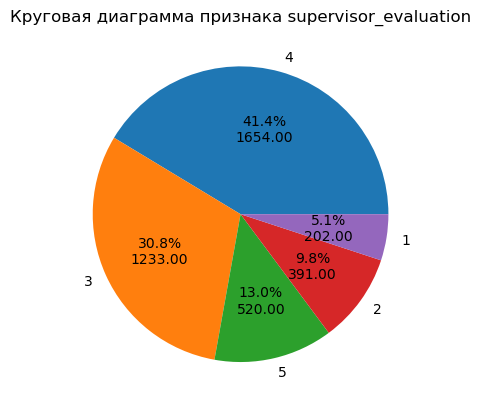

In [73]:
print_pie_bar(pd.concat([train_clf.select_dtypes(exclude='number'), train_clf['supervisor_evaluation']], axis = 1))

По всем признакам кроме таргета ситуация такая же, как и для прошлой задачи. А вот для таргета наблюдается очевидный дисбаланс классов. Уберем эту проблему также при составлении пайплайнов

#### Корреляционный анализ данных

Text(0.5, 1.0, 'корреляция $\\phi_K$')

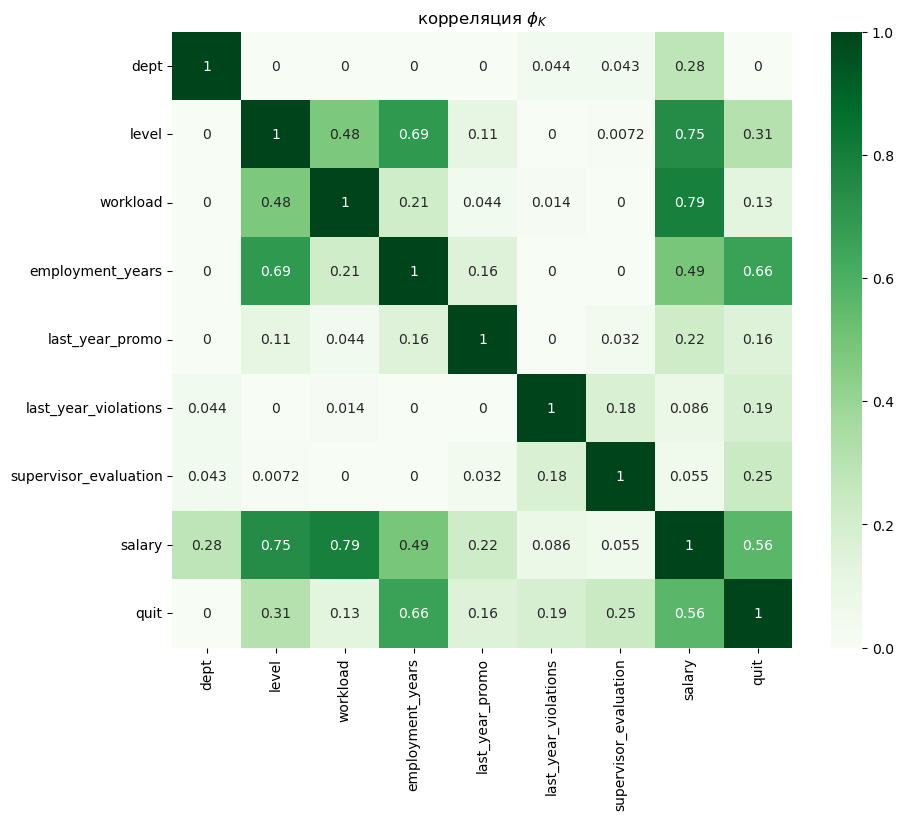

In [74]:
interval_columns = ['salary', 'employment_years']
plt.figure(figsize=(10, 8))
sns.heatmap(train_clf.drop(columns=['id']).phik_matrix(interval_cols=interval_columns), annot=True, cmap='Greens')
plt.title(r'корреляция $\phi_K$')

C:\Users\Maxim\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.08, 'зависимости одного признака от другого')

<Figure size 1500x1000 with 0 Axes>

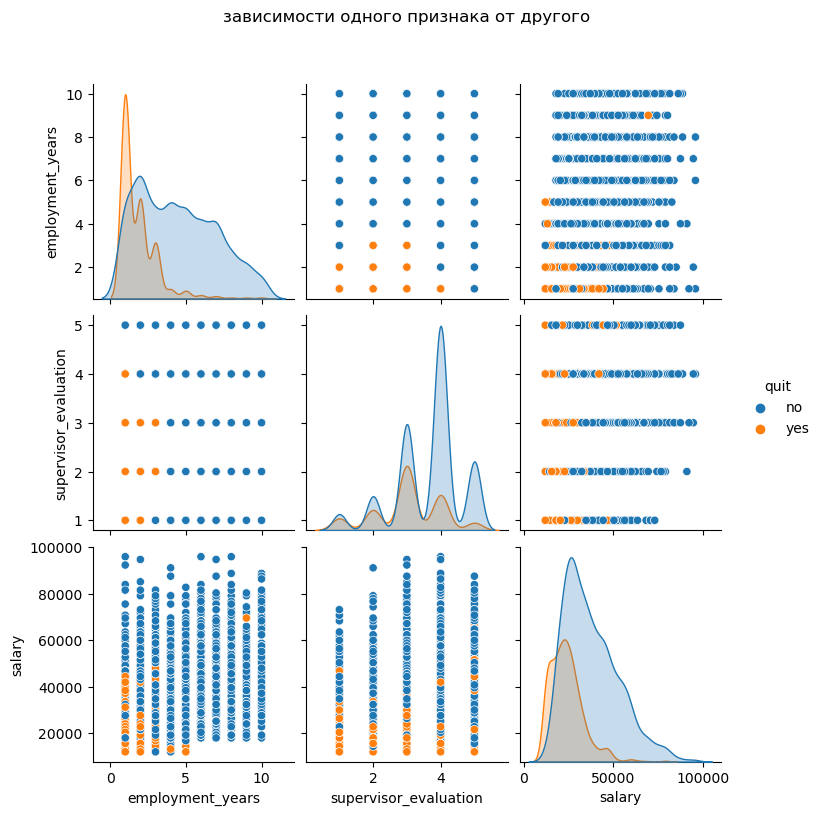

In [75]:
plt.figure(figsize=(15, 10))
g = sns.pairplot(train_clf.drop(columns=['id']), hue='quit')
g.fig.suptitle('зависимости одного признака от другого', y=1.08)

Не совсем верно отображать на скаттерплоте оценку, потому что это категориальный признак, но в данном случае можно, так как он порядковый.

По матрице корреляции и скаттерплотам можно сказать, что сильнее всего на вероятность ухода из компании влияют ЗП (чем меньше, тем выше вероятность ухода), опыт (чем меньше, тем выше вероятность ухода), уровень должности, и совершенно не влияет отдел, где работает сотрудник.

#### Составление портрета уволившегося сотрудника

Посотрим на матрицу корреляций уволившегося сотрудника

C:\Users\Maxim\anaconda3\Lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable quit for analysis 1. Dropping this column
  warnings.warn(


Text(0.5, 1.0, 'корреляция $\\phi_K$')

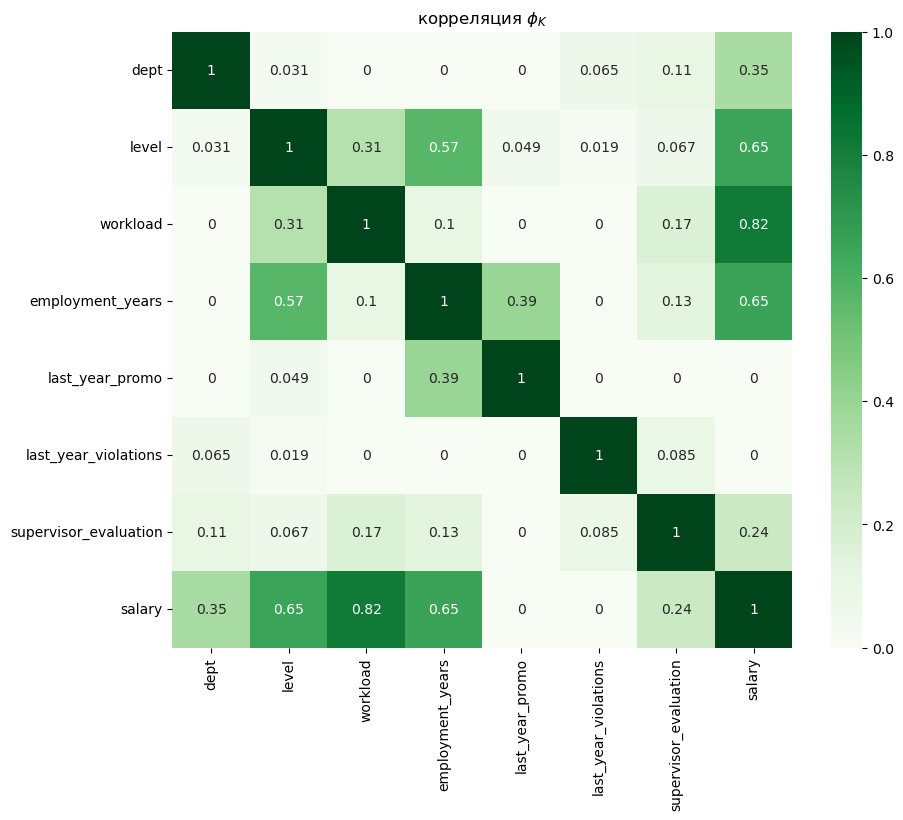

In [76]:
plt.figure(figsize=(10, 8))
sns.heatmap(train_clf[train_clf['quit'] == 'yes'].drop(columns=['id']).phik_matrix(interval_cols=interval_columns), annot=True, cmap='Greens')
plt.title(r'корреляция $\phi_K$')

В матрице коррляции ничего интрересного не видим, все то же, что и для полного датасета

count    1128.000000
mean        1.844858
std         1.274920
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        10.000000
Name: employment_years, dtype: float64


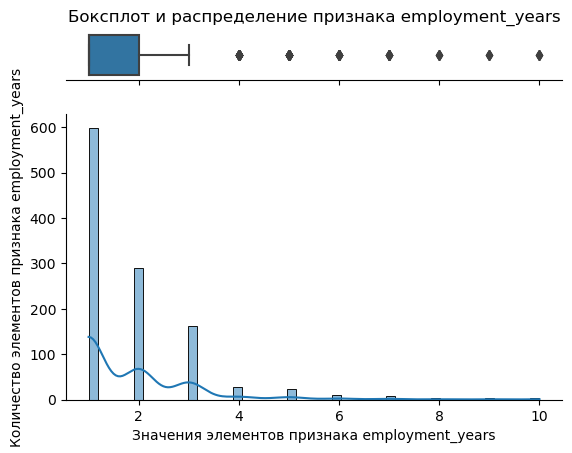

count     1128.000000
mean     23885.106383
std       9351.599505
min      12000.000000
25%      16800.000000
50%      22800.000000
75%      27600.000000
max      79200.000000
Name: salary, dtype: float64


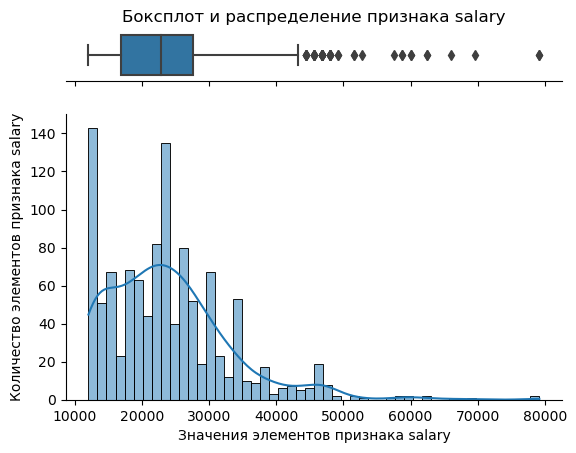

In [77]:
print_hist_box(train_clf[train_clf['quit'] == 'yes'].select_dtypes(include='number').drop(columns=['id', 'supervisor_evaluation']))

count      1128
unique        5
top       sales
freq        407
Name: dept, dtype: object


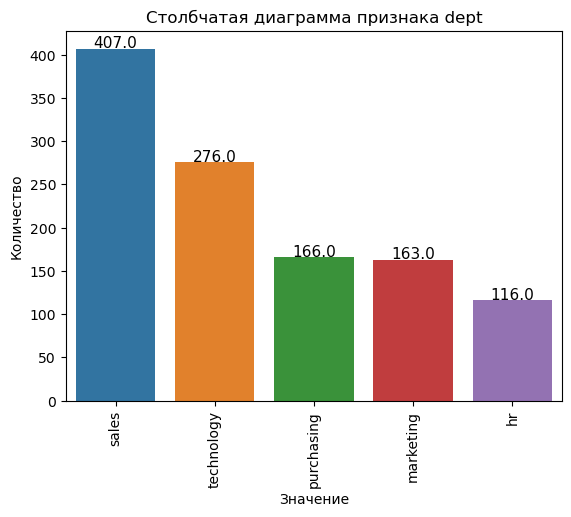

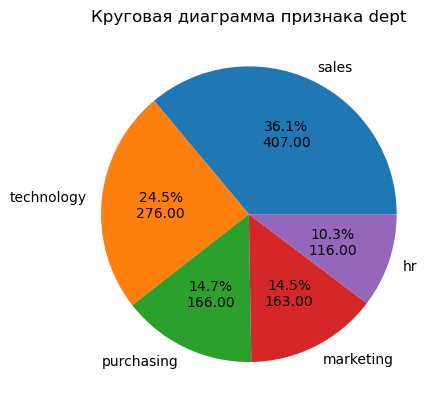

count       1128
unique         3
top       junior
freq        1003
Name: level, dtype: object


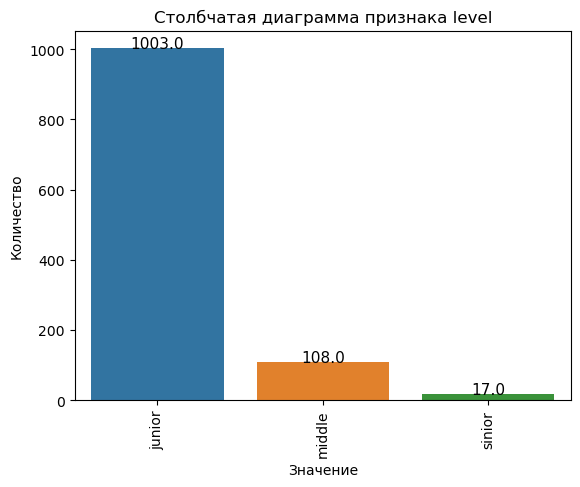

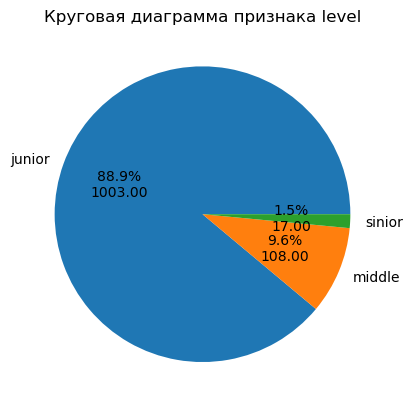

count     1128
unique       3
top        low
freq       519
Name: workload, dtype: object


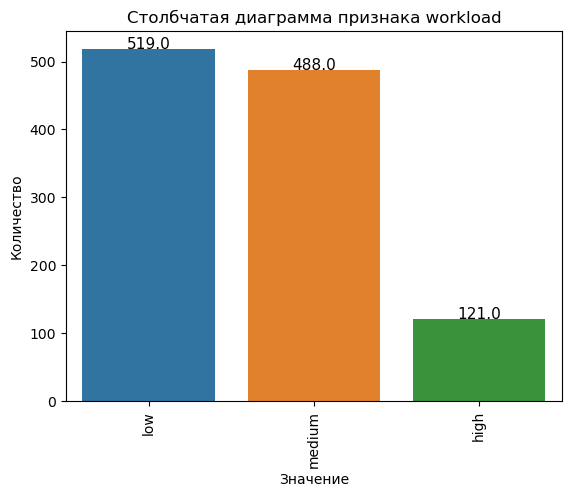

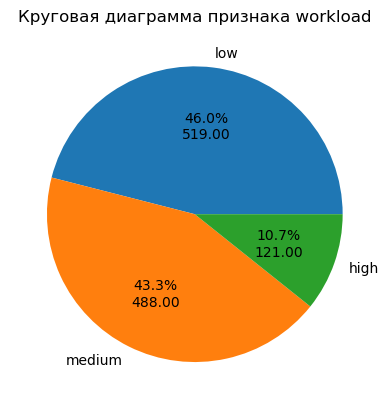

count     1128
unique       2
top         no
freq      1127
Name: last_year_promo, dtype: object


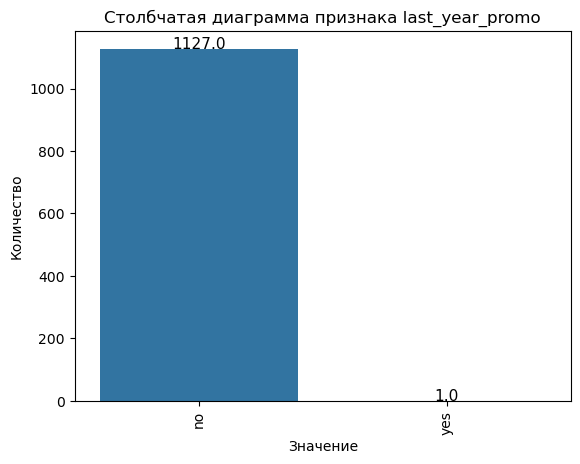

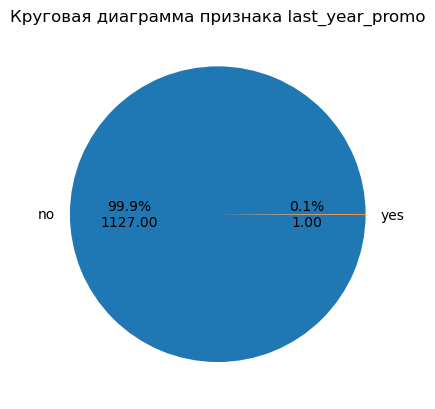

count     1128
unique       2
top         no
freq       900
Name: last_year_violations, dtype: object


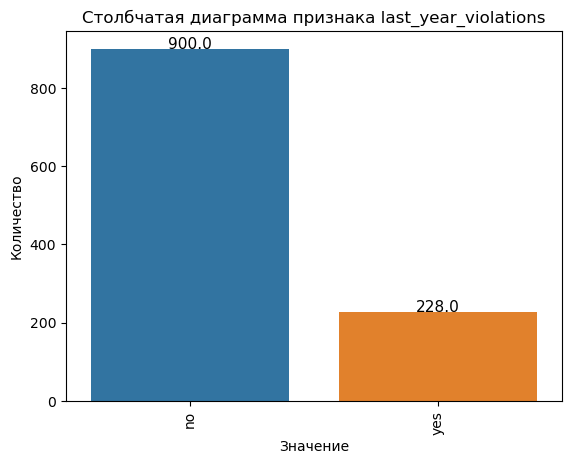

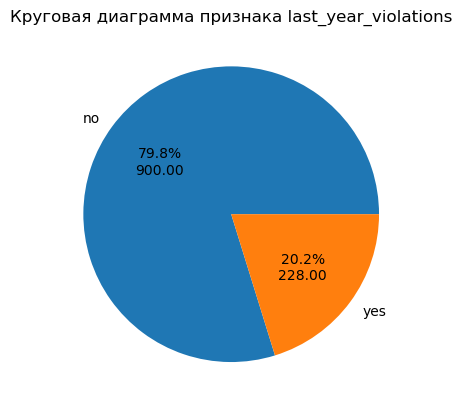

count     1128
unique       1
top        yes
freq      1128
Name: quit, dtype: object


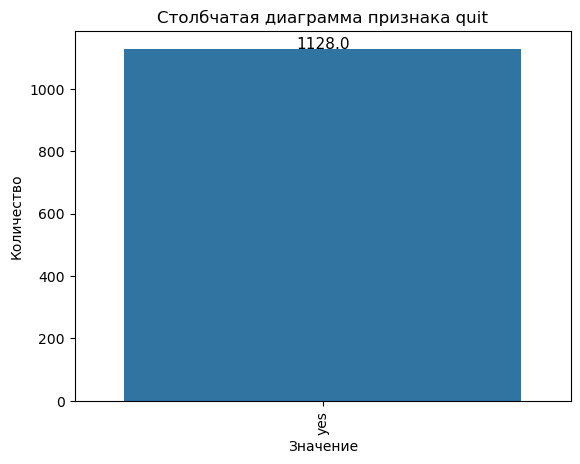

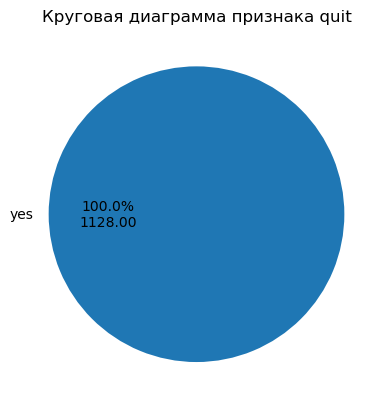

count    4000.000000
mean        3.474750
std         1.004049
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


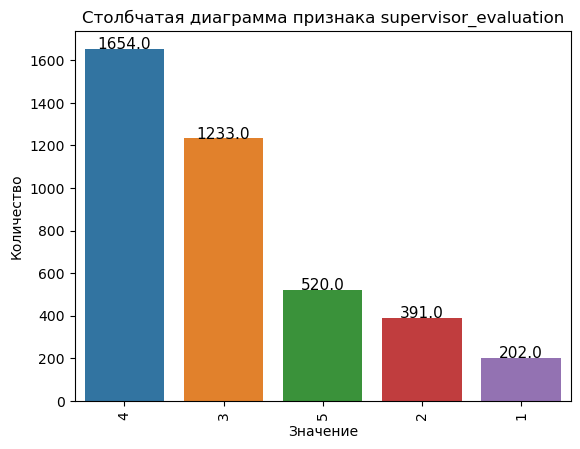

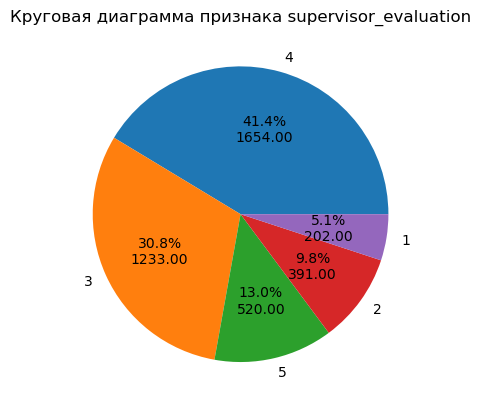

In [78]:
print_pie_bar(pd.concat([train_clf[train_clf['quit'] == 'yes'].select_dtypes(exclude='number'), train_clf['supervisor_evaluation']], axis = 1))

Итак **портрет**: человек, который потенциально может уволиться -
- ЗП меньше 40000, а в среднем 23885
- опыт работы в компании меньше 3-х лет
- количество "желающих уволиться" пропорционально количеству людей в отделе и не влияет на желание
- уровень должности - джуниор
- уровень загруженности средний и низкий, но почти не влияет
- не получал повышение в прошлом году
- вероятно, нарушал трудовой в прошлом году
- от оценки начальника почти не зависит

In [79]:
print('доля сотрудников, желающих уволится с ЗП < 40000 от все сотрудников с ЗП < 40000: ', 
      len(train_clf[(train_clf['quit'] == 'yes') & (train_clf['salary'] < 40000)]) / len(train_clf[(train_clf['salary'] < 40000)]))

доля сотрудников, желающих уволится с ЗП < 40000 от все сотрудников с ЗП < 40000:  0.37123862841147653


In [80]:
print('доля сотрудников, желающих уволится с опытом <= 3 лет от все сотрудников с опытом <= 3 лет: ',
      len(train_clf[(train_clf['quit'] == 'yes') & (train_clf['employment_years'] <= 3)]) / len(train_clf[(train_clf['employment_years'] < 3)]))

доля сотрудников, желающих уволится с опытом <= 3 лет от все сотрудников с опытом <= 3 лет:  0.5970488081725313


In [81]:
for dept in train_clf['dept'].unique():
    print(f"доля сотрудников, желающих уволится из отдела {dept} от все сотрудников {dept} {len(train_clf[(train_clf['quit'] == 'yes') & (train_clf['dept'] == dept)]) / len(train_clf[train_clf['dept'] == dept])}")

доля сотрудников, желающих уволится из отдела sales от все сотрудников sales 0.28303198887343534
доля сотрудников, желающих уволится из отдела purchasing от все сотрудников purchasing 0.282312925170068
доля сотрудников, желающих уволится из отдела marketing от все сотрудников marketing 0.2800687285223368
доля сотрудников, желающих уволится из отдела technology от все сотрудников technology 0.2974137931034483
доля сотрудников, желающих уволится из отдела hr от все сотрудников hr 0.25


Отдел не влияет, как и было сказано заранее

In [82]:
print('доля сотрудников, желающих уволится - джунов от всех сотрудников-джунов: ', 
      len(train_clf[(train_clf['quit'] == 'yes') & (train_clf['level'] == 'junior')]) / len(train_clf[(train_clf['level'] == 'junior')]))

доля сотрудников, желающих уволится - джунов от всех сотрудников-джунов:  0.5146228835300154


In [83]:
print('доля сотрудников, желающих уволится - джунов от всех сотрудников в целом: ', 
      len(train_clf[(train_clf['quit'] == 'yes') & (train_clf['level'] == 'junior')]) / len(train_clf))

доля сотрудников, желающих уволится - джунов от всех сотрудников в целом:  0.25075


In [84]:
for workload in train_clf['workload'].unique():
    print(f"доля сотрудников, желающих уволится c загруженностью {workload} от все сотрудников {workload} c загруженностью \
    {len(train_clf[(train_clf['quit'] == 'yes') & (train_clf['workload'] == workload)]) / len(train_clf[train_clf['workload'] == workload])}")

доля сотрудников, желающих уволится c загруженностью high от все сотрудников high c загруженностью     0.1795252225519288
доля сотрудников, желающих уволится c загруженностью medium от все сотрудников medium c загруженностью     0.23040604343720492
доля сотрудников, желающих уволится c загруженностью low от все сотрудников low c загруженностью     0.429635761589404


In [85]:
print('доля сотрудников, желающих уволится, которые не получали повышение в прошлом году от всех сотрудников не получавших повышение в прошлом году: ', 
      len(train_clf[(train_clf['quit'] == 'yes') & (train_clf['last_year_promo'] == 'no')]) / len(train_clf[(train_clf['last_year_promo'] == 'no')]))

доля сотрудников, желающих уволится, которые не получали повышение в прошлом году от всех сотрудников не получавших повышение в прошлом году:  0.28994082840236685


In [86]:
print('доля сотрудников, желающих уволится, которые !получали повышение в прошлом году от всех сотрудников !получавших повышение в прошлом году: ', 
      len(train_clf[(train_clf['quit'] == 'yes') & (train_clf['last_year_promo'] == 'yes')]) / len(train_clf[(train_clf['last_year_promo'] == 'yes')]))

доля сотрудников, желающих уволится, которые !получали повышение в прошлом году от всех сотрудников !получавших повышение в прошлом году:  0.008849557522123894


Почти никто!

In [87]:
print('доля сотрудников, желающих уволится, которые нарушали ТД в прошлом году от всех сотрудников нарушавших ТД в прошлом году: ', 
      len(train_clf[(train_clf['quit'] == 'yes') & (train_clf['last_year_violations'] == 'yes')]) / len(train_clf[(train_clf['last_year_violations'] == 'yes')]))

доля сотрудников, желающих уволится, которые нарушали ТД в прошлом году от всех сотрудников нарушавших ТД в прошлом году:  0.41834862385321103


In [88]:
for mark in train_clf['supervisor_evaluation'].unique():
    print(f"доля сотрудников, желающих уволится c оценкой {mark} от все сотрудников c оценкой {mark} c загруженностью \
    {len(train_clf[(train_clf['quit'] == 'yes') & (train_clf['supervisor_evaluation'] == mark)]) / len(train_clf[train_clf['supervisor_evaluation'] == mark])}")

доля сотрудников, желающих уволится c оценкой 4 от все сотрудников c оценкой 4 c загруженностью     0.17291414752116083
доля сотрудников, желающих уволится c оценкой 1 от все сотрудников c оценкой 1 c загруженностью     0.47029702970297027
доля сотрудников, желающих уволится c оценкой 3 от все сотрудников c оценкой 3 c загруженностью     0.42416869424168696
доля сотрудников, желающих уволится c оценкой 5 от все сотрудников c оценкой 5 c загруженностью     0.11538461538461539
доля сотрудников, желающих уволится c оценкой 2 от все сотрудников c оценкой 2 c загруженностью     0.4194373401534527


Доли еще раз подтвердили сделанные ранее выводы

#### Исследование влияния уровня удовлетвореннсти сотрудника на увольнение

Посмотрим на распределение уровня удовлетворенности для желающих уволиться и нет, но для начала добавим этот показатель путем предсказания

In [89]:
train_clf['job_satisfaction_rate'] = grid_search.predict(train_clf.drop(columns=['id']))
train_clf.head()

id        dept   level workload  employment_years last_year_promo  \
0  723290       sales  middle     high                 2              no   
1  814010       sales  junior   medium                 2              no   
2  155091  purchasing  middle   medium                 5              no   
3  257132       sales  junior   medium                 2              no   
4  910140   marketing  junior   medium                 2              no   

  last_year_violations  supervisor_evaluation  salary quit  \
0                   no                      4   54000   no   
1                   no                      4   27600   no   
2                   no                      1   37200   no   
3                  yes                      3   24000  yes   
4                   no                      5   25200   no   

   job_satisfaction_rate  
0               0.635385  
1               0.821905  
2               0.337500  
3               0.340000  
4               0.812500

count    1128.000000
mean        0.401307
std         0.186757
min         0.060000
25%         0.253750
50%         0.353750
75%         0.525385
max         0.883333
Name: job_satisfaction_rate, dtype: float64


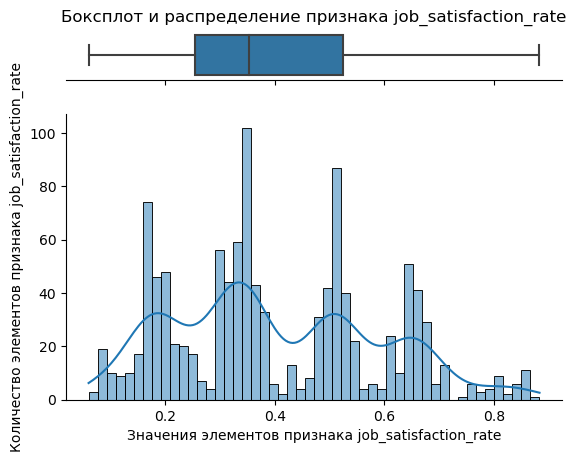

In [90]:
print_hist_box(train_clf[train_clf['quit'] == 'yes']['job_satisfaction_rate'].to_frame())

count    2872.000000
mean        0.590013
std         0.202166
min         0.076667
25%         0.453846
50%         0.644615
75%         0.767143
max         0.964286
Name: job_satisfaction_rate, dtype: float64


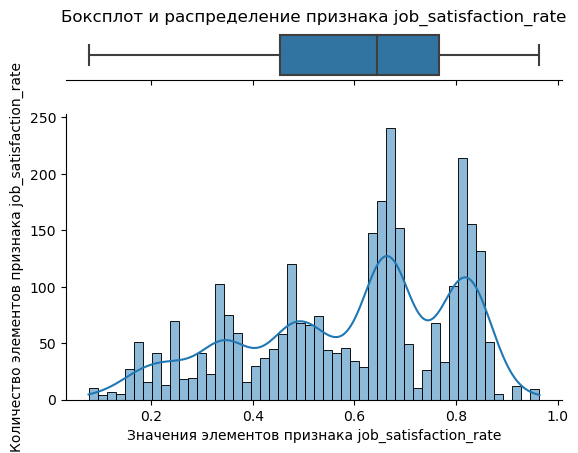

In [91]:
print_hist_box(train_clf[train_clf['quit'] == 'no']['job_satisfaction_rate'].to_frame())

Связь и правда присутствует: 
- основная масса тех, кто хочет уволиться довольны своей работой в среднем на 0.4 или до 0.6. В целом по графику можем видеть интересное распределение с тремя пиками. В целом, похоже на правду
- основная масса тех, кто **не** хочет уволиться довольны своей работой в среднем на больше 0.6. По графику это видно, что тоже соответствует действительности

Проведем статистический тест с для сравнения распределений признака job_satisfaction_rate для ушедших и оставшихся работников:
- Н0 - две выборки имеют одинаквое распрделение.
- Н1 - выборка "увольняющихся" имеет меньшее распределение, чем неувольняющихся

In [92]:
st.mannwhitneyu(train_clf[train_clf['quit'] == 'yes']['job_satisfaction_rate'], train_clf[train_clf['quit'] == 'no']['job_satisfaction_rate'].to_frame(), alternative='less')

MannwhitneyuResult(statistic=array([ 437. ,   13.5,  186.5, ..., 1283. , 1124.5,  923. ]), pvalue=array([0.11430474, 0.04321052, 0.06603478, ..., 0.4270546 , 0.35383378,
       0.26830397]))

P-value вообще крошечный, так что если даже возьмем значимость, как медики, 0.01, то все равно отвергнем нулевую. Собственно, выводы подтвердились

### Добавление нового входного признака <a id='new_feature'>

В обучающую выборку мы уже добавили признак `job_satisfaction_rate`. Осталось добавить его в тествовый датасет. А для тестового датасета этот признак был таргетом для первой задачи, поэтому просто добавим его

In [93]:
X_test_clf = X_test_clf.join(y_test)
X_test_clf.head()

dept   level workload  employment_years last_year_promo  \
id                                                                     
485046  marketing  junior   medium                 2              no   
686555         hr  junior   medium                 1              no   
467458      sales  middle      low                 5              no   
418655      sales  middle      low                 6              no   
789145         hr  middle   medium                 5              no   

       last_year_violations  supervisor_evaluation  salary  \
id                                                           
485046                   no                      5   28800   
686555                   no                      4   30000   
467458                   no                      4   19200   
418655                   no                      4   19200   
789145                   no                      5   40800   

        job_satisfaction_rate  
id                             
485046                   0.79  
686555                   0.72  
467458                   0.64  
418655                   0.60  
789145                   0.75

### Подготовка данных <a id='data_prep_models2'>

Для начала выделим таргет и признаковок из обучающей выборки

Уберем отдел, так как он вообще не влияет на урольнение

In [94]:
y_train_clf = train_clf['quit']
X_train_clf = train_clf.drop(columns=['id', 'quit', 'dept'])
X_train_clf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   level                  4000 non-null   object 
 1   workload               4000 non-null   object 
 2   employment_years       4000 non-null   int64  
 3   last_year_promo        4000 non-null   object 
 4   last_year_violations   4000 non-null   object 
 5   supervisor_evaluation  4000 non-null   int64  
 6   salary                 4000 non-null   int64  
 7   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(4)
memory usage: 250.1+ KB


Закодируем таргет

In [95]:
le = LabelEncoder()
y_train_clf = le.fit_transform(y_train_clf)
y_test_clf = le.transform(y_test_clf)
le.classes_

array(['no', 'yes'], dtype=object)

In [96]:
ohe_columns = ['last_year_promo',  'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = train_clf.drop(columns=['id', 'supervisor_evaluation']).select_dtypes(include='number').columns

In [97]:
ohe_pipe_clf = Pipeline(
    [
        ('ohe_imp', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
)

In [98]:
ord_pipe_clf = Pipeline(
    [
        ('ord_imp', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(categories=
                              [
                                  ['junior', 'middle', 'sinior'],
                                  ['low', 'medium', 'high']
                              ], handle_unknown='use_encoded_value', unknown_value=np.nan)),
        ('imp_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [99]:
col_transformer_clf = ColumnTransformer(
    [
        ('ohe', ohe_pipe_clf, ohe_columns),
        ('ord', ord_pipe_clf, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

**Вывод по пункту**: был собран пайплайн для подготовки признаков, было учтено, что надо заполнить пропуски, которые не были заполнены при предобработке и что в тестовой выборке есть неизвестные данные, а также закодирован таргет. 

### Обучение модели <a id='training2'>

In [100]:
final_pipe_clf = Pipeline(
    [
        ('prep', col_transformer_clf),
        ('feature_selection', SelectKBest(score_func=f_regression, k=11)),
        ('sampling', RandomOverSampler(random_state=RANDOM_STATE)),
        ('models', LogisticRegression())
    ]
)

In [101]:
params_clf = [
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE,
                                      penalty='l1',
                                      solver='saga'),
                   LogisticRegression(random_state=RANDOM_STATE,
                                      penalty='l2')],
        'models__C': [0.1, 0.5, 1, 5, 10],
        'prep__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
        'feature_selection__k': range(4, 8),
        'sampling': [SMOTE(random_state=RANDOM_STATE), RandomUnderSampler(random_state=RANDOM_STATE)]
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': [0.1, 0.5, 1, 10, 50, 100, 150, 200],
        'models__kernel': ['rbf'],
        'prep__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
        'feature_selection__k' : range(4, 8), # found optimal
        'sampling': [SMOTE(random_state=RANDOM_STATE), RandomUnderSampler(random_state=RANDOM_STATE)]
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 8),
        'models__min_samples_split': range(2, 8),
        'models__min_samples_leaf': range(2, 8),
        'feature_selection__k' : range(4, 8),
        'prep__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
        'sampling': [SMOTE(random_state=RANDOM_STATE), RandomUnderSampler(random_state=RANDOM_STATE)]
        
    },
]

In [102]:
random_search = RandomizedSearchCV(
    final_pipe_clf,
    param_distributions=params_clf,
    scoring='roc_auc',
    n_jobs=-1,
    n_iter=100,
    random_state=RANDOM_STATE
)

In [103]:
random_search.fit(X_train_clf, y_train_clf)

RandomizedSearchCV(estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe_imp',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('ord_imp',
                                                                                                SimpleImputer(strategy='mo...
                                        {'feature_selection__k': range(4, 8),
                                         'models': [DecisionTreeClassifier(random_state=42)],
                                         'models__max_depth': range(2, 8),
                                         'models__min_samples_leaf': range(2, 8),
                                         'models__min_samples_split': range(2, 8),
                                         'prep__num': [StandardScaler(),
                                                       MinMaxScaler(),
                                                       RobustScaler(),
                                                       'passthrough'],
                                         'sampling': [SMOTE(random_state=42),
                                                      RandomUnderSampler(random_state=42)]}],
                   random_state=42, scoring='roc_auc')

In [104]:
random_search.best_estimator_

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe_imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord_imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   Ordinal...
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload']),
                                                 ('num', RobustScaler(),
                                                  Index(['employment_years', 'salary', 'job_satisfaction_rate'], dtype='object'))])),
                ('feature_selection',
                 SelectKBest(k=6,
                             score_func=<function f_regression at 0x00000259AD6268E0>)),
                ('sampling', SMOTE(random_state=42)),
                ('models', SVC(C=1, probability=True, random_state=42))])

In [105]:
random_search.best_score_

0.9301920821090693

In [106]:
random_search.best_params_

{'sampling': SMOTE(random_state=42),
 'prep__num': RobustScaler(),
 'models__kernel': 'rbf',
 'models__C': 1,
 'models': SVC(C=1, probability=True, random_state=42),
 'feature_selection__k': 6}

In [107]:
roc_auc_score(y_test_clf, random_search.predict_proba(X_test_clf)[:, 1])

0.9305176909855982

**Вывод по пунтку**: Были опробованы следующие модели и гиперпараметры к ним:
- LogisticRegression с L1 и L2 регуляризацией
- SVC
- DecisionTreeClassifier
- Лучшей моделью стала `SVC` со следующими гиперпараметрами:
    1. 'sampling': `SMOTE(random_state=RANDOM_STATE)`,
    2. 'prep__num': `RobustScaler()`,
    3. 'models__kernel': `'rbf'`,
    4. 'models__C': 1,
    5. 'models': `SVC(probability=True, random_state=RANDOM_STATE)`,
    6. 'feature_selection__k': 6
- метрика `roc_auc` на обучающей выборке составила `0.9302`
- метрика `roc_auc` на тестовой выборке составила `0.9305`

### Выводы

Повторим часть вывода из прошлого пункта:
- Лучшей моделью стала `SVC` со следующими гиперпараметрами:
    1. 'sampling': `SMOTE(random_state=RANDOM_STATE)`,
    2. 'prep__num': `RobustScaler()`,
    3. 'models__kernel': `'rbf'`,
    4. 'models__C': 1,
    5. 'models': `SVC(probability=True, random_state=RANDOM_STATE)`,
    6. 'feature_selection__k': 6

Добавим, что 
- лучше всех справилась модель `SVC` возможно потому, что данные имеют слабые линейные зависимости, а благодаря ядру `rbf` модель смогла лучше проанализировать закономерности

## Общий вывод <a id='conc'>

Было поставлено 2 задачи:
- построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика
- построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании
<br><br>
**Начнем с первой задачи:**
- На этапе предобработки было сделано:
    1. проведена работа с пропусками
    2. проведена работа с дубликатами
- На этапе исследовательского анализа было сделано:
    1. были выявлены зависимости с таргетом
    2. изучено распределение каждого признака
    3. сделан вывод о том, что стоит закодировать порядковые признаки с помощью `OrdinalEncoder`
    4. сделан вывод о том, чтостоит закодировать номинальные и бинарные признаки с помощью `OneHotEncoder`
    5. сделан вывод о том, что масштабирование попробуем разными способами
    6. сделан вывод о том, что все выявленные сильные зависимости - линейные
- На этапе подготовки признаков было сделано:
    1. был собран пайплайн для подготовки признаков
    2. было учтено, что надо заполнить пропуски, которые не были заполнены при предобработке
    3. было учтено, что в тестовой выборке есть неизвестные данные.
- На этапе обучения и выбора лучшей модели было сделано:
    1. Были опробованы слудующие модели и пдобраны к ним гиперпараментры:
        - Ridge
        - Lasso
        - LinearRegression
        - SVR
        - DecisionTreeRegressor
    2. Лушчей стала модель `DecisionTreeRegressor` со следующими гиперпараметрами:
        - 'prep__num': `StandardScaler()`,
        - 'models__min_samples_split': 4,
        - 'models__min_samples_leaf': 3,
        - 'models__max_depth': 45,
        - 'models': `DecisionTreeRegressor(random_state=RANDOM_STATE)`,
        - 'feature_selection__score_func': `f_regression`,
        - 'feature_selection__k': 10
    3. качество модели по метрике `smape` на обучающей выборке составило 14.57
    4. качество модели по метрике `smape` на тествовой выборке составило 13.64
<br><br>
**Для второй задачи:**
- На этапе предобработки было сделано:
    1. проведена работа с пропусками
    2. проведена работа с дубликатами
- На этапе исследовательского анализа было сделано:
    1. были выявлены зависимости с таргетом
    2. изучено распределение каждого признака
    3. было выявлено, что сильнее всего на вероятность ухода из компании влияют ЗП , опыт , уровень должности, и совершенно не влияет отдел, где работает сотрудник.
    4. был составлен портрет сотрудника, который хочет уволиться
    5. изучено влияние удовлетворенности работой на желание увоиться
- На этапе подготовки признаков было сделано:
    1. был собран пайплайн для подготовки признаков
    2. было учтено, что надо заполнить пропуски, которые не были заполнены при предобработке
    3. было учтено, что в тестовой выборке есть неизвестные данные.
- На этапе обучения и выбора лучшей модели было сделано:
    1. Устранен дисбаланс классов  
    1. Были опробованы слудующие модели и пдобраны к ним гиперпараментры:
        - LogisticRegression с L1 и L2 регуляризацией
        - SVC
        - DecisionTreeClassifier
    2. Лучшей моделью стала `SVC` со следующими гиперпараметрами:
        - 'sampling': `SMOTE(random_state=RANDOM_STATE)`,
        - 'prep__num': `RobustScaler()`,
        - 'models__kernel': `'rbf'`,
        - 'models__C': 1,
        - 'models': `SVC(probability=True, random_state=RANDOM_STATE)`,
        - 'feature_selection__k': 6
    3. метрика `roc_auc` на обучающей выборке составила `0.9302`
    4. метрика `roc_auc` на тестовой выборке составила `0.9305`
<br><br>
По причине того, что в ообеих задачах модели без бустинга показали себя весьма неплохо, было принято решение модели бустинга в этом проекте не обучать 
<br><br>
**Рекомендации для первой задачи:**
- на уровень удовлетворенности очень сильно влияет оценка руководителя, поэтому, если человек знает об оценке, возможно скрывать ее от него или говорить, что он плохо работает как-то заэвуалированно, мягко
- на втором месте там идет ЗП. (ЗП большой не бывает, тут и так понятно)
<br><br>
**Рекомендации для второй задачи:**
- на вероятность ухода больше всего влияют ЗП и стаж в комнании, что логично, потому что часто люди "бегают" от работодателя к работодателю в поисках большей ЗП, как правило. Поэтому если сотрудник еще неопытен, но уже можно сказать, что он способный, то стоит поднять ему ЗП, чтобы конкуренты не переманили к себе.